## ¿Qué problema se va a resolver?
El tema de investigación surgió por la necesidad que tienen las empresas operadoras de taxis de la ciudad de Bogotá, estas vienen presentando una creciente problemática de indisponibilidad de servicios de taxis en sus plataformas, esto suceso ocurre principalmente en algunas zonas u horarios específicos.
La empresa Taxis Libres (TL), una de las más grandes operadoras de servicios de taxis de la ciudad, ha empezado a recibir una gran cantidad de inconformidades por partes de los usuarios recurrentes de la plataforma por esta misma causa. Solo en el mes de mayo del 2022 la plataforma recibió alrededor de 1.2 millones de solicitudes de servicios de taxis de los cuales el 57% de esas solicitudes fueron abandonadas o rechazadas, lo que los llevó a analizar qué estaba pasando con la prestación de servicios internamente, en esa revisión realizada durante el mismo periodo de tiempo se obtuvieron las principales causas reportadas en la plataforma y que se listarán a continuación:

•	El usuario se fue

•	El vehículo se demoró en llegar

•	El usuario tomó otro taxi

Al identificar las causas de los servicios abandonados y rechazados, la empresa se planteó a resolver la siguiente pregunta al problema presentado.
¿Como reducir la alta cantidad de inconformidades de los usuarios recurrentes de la plataforma prediciendo sus comportamientos durante la semana y así programarles sus servicios de forma anticipada?

## Objetivo general
Diseñar un método para predecir las solicitudes de servicios de los usuarios recurrentes "de empresas de servicios de" taxis en la ciudad Bogotá - Colombia, "mediante" modelos de ML.


Evaluar el desempeño de modelos de ML para predecir
las solicitudes de servicios de los usuarios recurrentes de empresas de servicios de taxis en la ciudad Bogotá -  Colombia
basados en el comportamiento dentro de la plataforma.

## Objetivos específicos (Detallar las actividades)
• Revisar la literatura de al menos 10 artículos de proyectos relacionados (pendiente)

• Analizar los datos de los últimos 6 meses de servicios de la empresa taxis libres.

• Determinar las variables significativas a ser empleadas en los modelos de ML.

• Evaluar diferentes modelos de ML para la predicción de solicitudes.

## ¿Que solución propone al problema?
El diseño de un modelo predictivo de solicitudes de servicios de taxis basados en comportamientos de usuarios recurrentes de plataformas móviles para empresas de transporte

## ¿Cómo lo pretende solucionar?
Utilizando un modelo de clasificación donde se agrupe la información de los servicios que han tomado los usuarios por días de las semanas y horarios, determinando si en ese día y a esa hora se va a tomar un servicio.

## ¿Que resultados que espera obtener?
Se espera obtener listado por día de las semanas con todos los horarios del día y un determinador que indique si el servicio se va a tomar o no en ese horario. 

### Exploratory data analysis

Project library definition

In [1]:
!pip install holidays

  Obtaining dependency information for holidays from https://files.pythonhosted.org/packages/4d/bd/1869fa353dfaf3390f6d47df683d9a32a527803e5be54d74606be8b89eee/holidays-0.31-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.3/754.3 kB 16.4 MB/s eta 0:00:0000:01


In [ ]:
!pip install fastparquet

In [ ]:
#librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.metrics import plot_confusion_matrix
from matplotlib.colors import ListedColormap
#from mlxtend.plotting import plot_decision_regions
#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron

#from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score

import numpy as np
#from numpy import NaN
from datetime import datetime, timedelta
import holidays
#from os import name
import math
from multiprocessing import Pool
import time

The initial parameters are defined

In [ ]:
TRAIN_WEEK = 6.0
TEST_WEEK = 1.0
BOGOTA_CODE = 11001
HOURS_OF_DAY = 24
WEEKS_RECURRENT = 5
FORMAT_DATE = '%Y-%m-%d'
FORMAT_COMPLETE_DATE = '%Y-%m-%d %H:%M:%S'
DATE_START_TRAINIG = pd.to_datetime("2023-03-10", format=FORMAT_DATE)
FICHERO_DATA = 's3://taxis-ml-2023-05-27/data/SERVICIO_UNIFICADO_2023.parquet.gzip'

#Se obtiene la fecha de inicial de entrenamiento
last_date_dataset = DATE_START_TRAINIG - timedelta(weeks=TRAIN_WEEK)
#Se obtiene la fecha de inicial de entrenamiento
first_date_dataset = DATE_START_TRAINIG + timedelta(weeks=TEST_WEEK)


The data is loaded into the dataFrame

In [ ]:
#Se lee el archivo de un parquet a un dataframe
df_taxis = pd.read_parquet(FICHERO_DATA) 
#Se visualizan los datos
print(f"({len(df_taxis):,}) records were loaded into dataset!")

The data types of the dataset are displayed

In [ ]:
df_taxis.info()

Validates how many null values are present in the dataset

In [ ]:
df_taxis.isnull().sum()

Data is cleaned where the user is null

In [ ]:
df_taxis = df_taxis[~df_taxis['USER'].isnull()]

Dataset fields are displayed

In [ ]:
df_taxis.head(5)

In [ ]:
df_taxis.tail(5)

## Display of initial data

Dataset if filtred in final status and grouped calle,recepcion,web,externo, iontaxi, kisoko and reserva in others channels

In [ ]:
df_taxis = df_taxis[(df_taxis['STATUS']=='ABANDONADO') | (df_taxis['STATUS']=='CUMPLIDO') | (df_taxis['STATUS']=='CANCELADO') | (df_taxis['STATUS']=='FINALIZADO')].replace({"CHAT_BOT_659": "CHATBOT", 
                  "CHAT_BOT_689": "CHATBOT",
                  "CHAT_BOT_729": "CHATBOT", 
                  "CHAT_BOT_803": "CHATBOT", 
                  "CALLE": "OTROS", 
                  "WEB": "OTROS", 
                  "EXTERNO": "OTROS", 
                  "IONTAXI": "OTROS", 
                  "Kiosko #1": "OTROS", 
                  "Reserva": "OTROS", 
                  "RECEPCION": "OTROS"})

In [ ]:
tmp_taxis = df_taxis.copy()
tmp_taxis["DAYOFWEEK"] = df_taxis.DAYOFWEEK.replace({1: "MONDAY", 
                  2: "TUESDAY",
                  3: "WEDNESDAY", 
                  4: "THURSDAY", 
                  5: "FRIDAY", 
                  6: "SATURDAY", 
                  7: "SUNDAY"})
tmp_taxis["MONTH"] = df_taxis.MONTH.replace({1: "JANUARY", 
                  2: "FEBRUARY",
                  3: "MARCH", 
                  4: "APRIL", 
                  5: "MAY", 
                  6: "JUNE", 
                  7: "JULY", 
                  8: "AUGUST", 
                  9: "SEPTEMBER", 
                  10: "OCTOBER", 
                  11: "NOVEMBER",
                    12:"DECEMBER"})

The number of services in a period of time is displayed

In [13]:
df_taxis.groupby(['DATE'])['ID'].count().plot(kind='line',stacked=True, fontsize=14, xlabel="Date", ylabel="Amount of services", figsize=(12,8), rot=45)
plt.show()

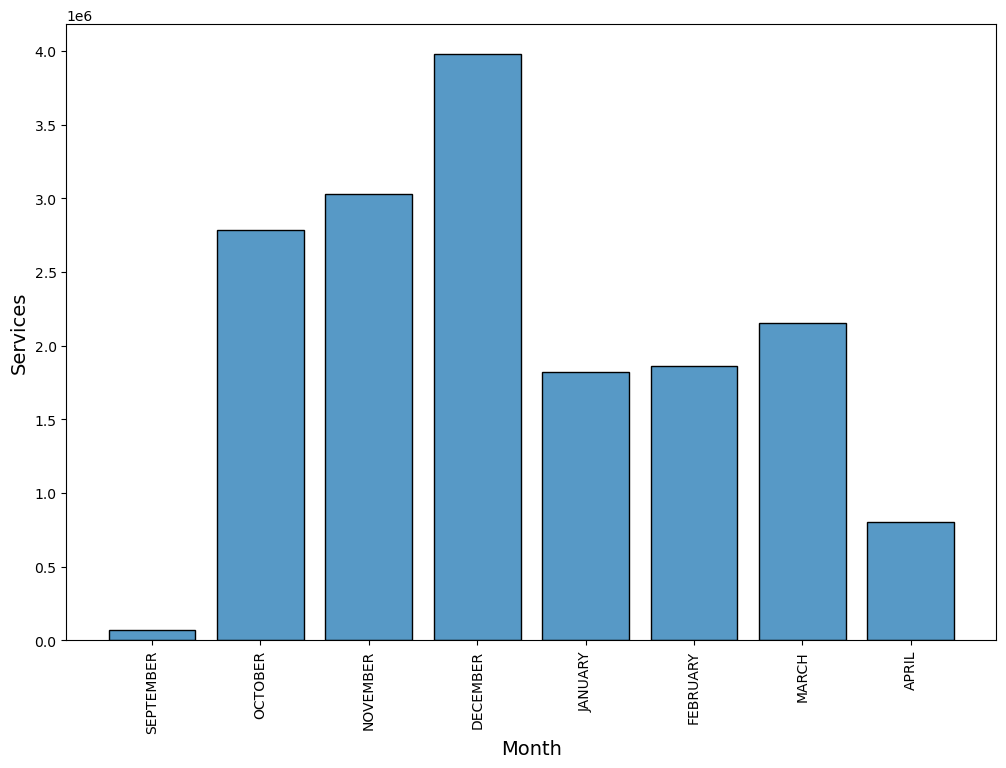

In [14]:
#Se visualiza porcentaje por mes
plt.figure(figsize=(12,8))
sns.histplot(data=tmp_taxis, x='MONTH', shrink=.8)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Services', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

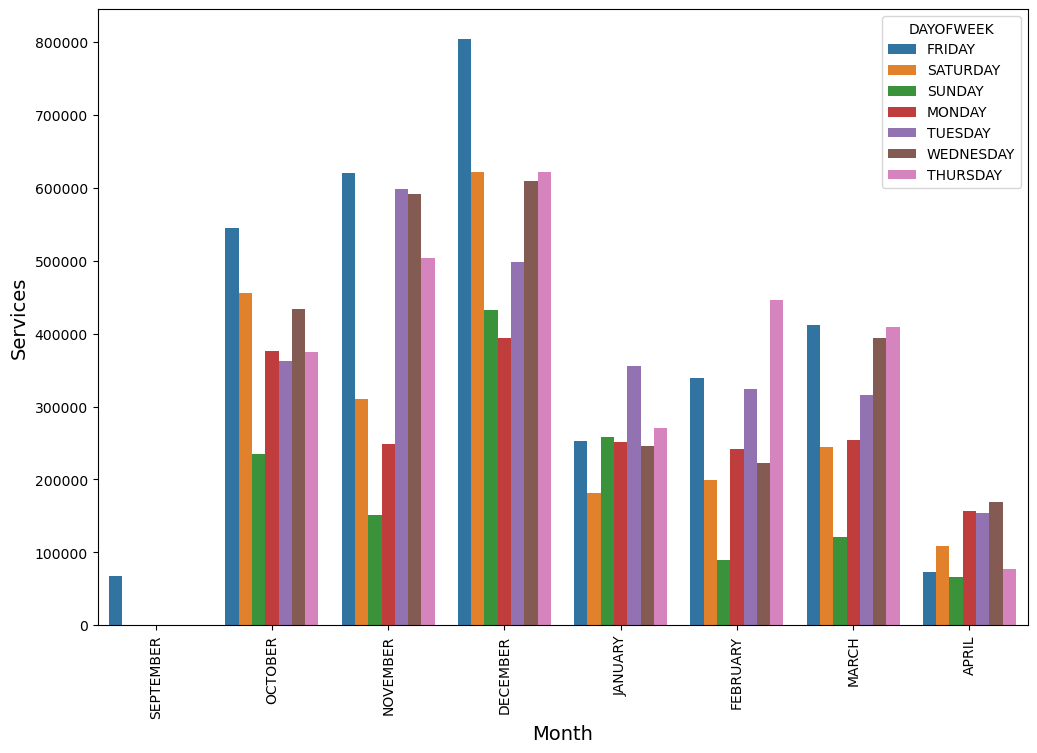

In [15]:
#Se visualiza porcentaje por mes y día de la semana
plt.figure(figsize=(12,8))
sns.countplot(data=tmp_taxis, x='MONTH',  hue="DAYOFWEEK")
plt.xlabel('Month', fontsize=14)
plt.ylabel('Services', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()


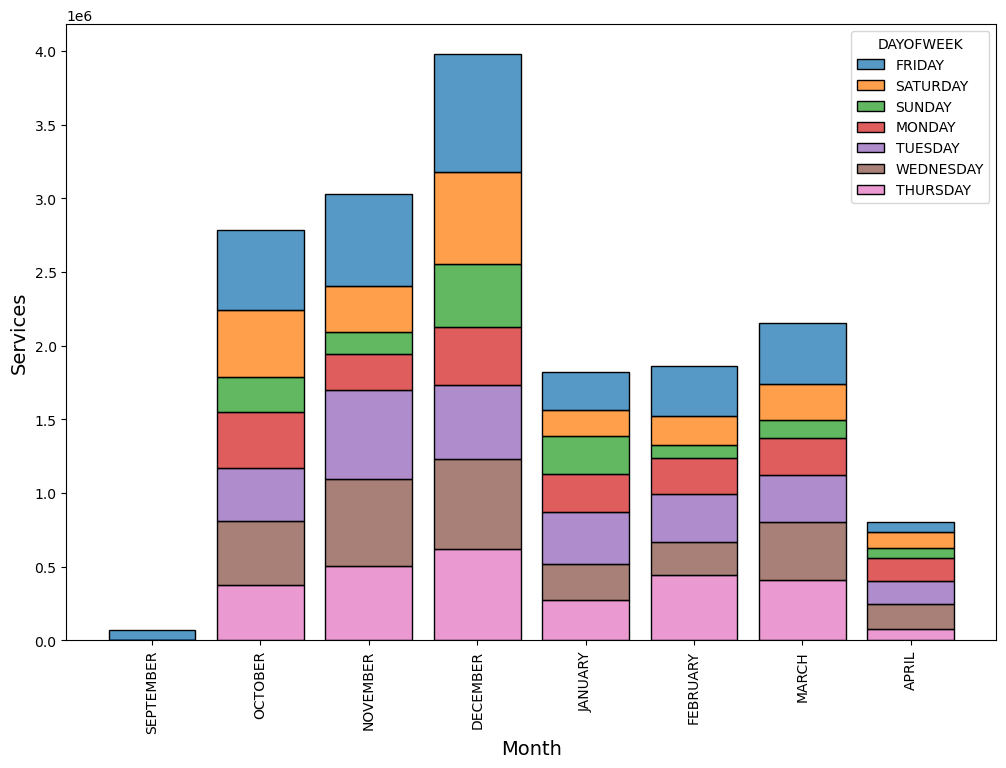

In [16]:
#Se visualiza porcentaje por mes y días de la semana
plt.figure(figsize=(12,8))
sns.histplot(data=tmp_taxis, x='MONTH', hue="DAYOFWEEK", multiple="stack", shrink=.8)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Services', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()


In [17]:
df_taxis.groupby(['MONTH'])['ID'].count()

MONTH
1     1817650
2     1861559
3     2151237
4      805306
9       67466
10    2784538
11    3026444
12    3981620
Name: ID, dtype: int64

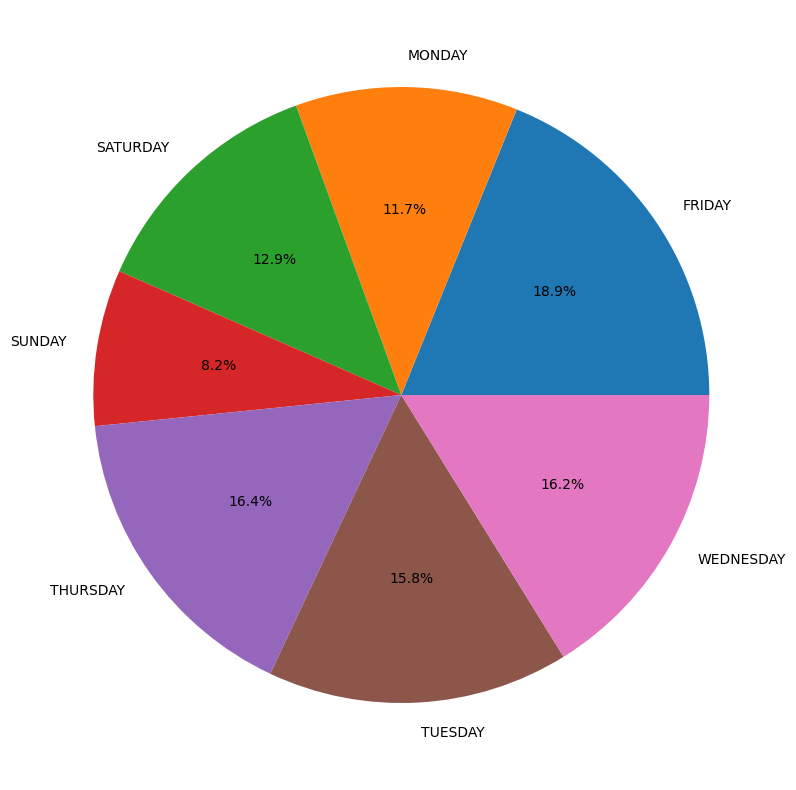

In [18]:
labels = ['FRIDAY','MONDAY','SATURDAY','SUNDAY', 'THURSDAY','TUESDAY', 'WEDNESDAY' ]

fig, ax = plt.subplots(figsize=(12, 8))
ax.pie(tmp_taxis.groupby(['DAYOFWEEK'])['ID'].count(), labels=labels, autopct='%.1f%%')
#ax.set_title('Distribution by days of week')
plt.tight_layout()
plt.show()

In [19]:
#TODO: delete this block
tmp_taxis.groupby(['DAYOFWEEK'])['USER'].count()

DAYOFWEEK
FRIDAY       3115291
MONDAY       1924731
SATURDAY     2122023
SUNDAY       1352616
THURSDAY     2703662
TUESDAY      2610410
WEDNESDAY    2667087
Name: USER, dtype: int64

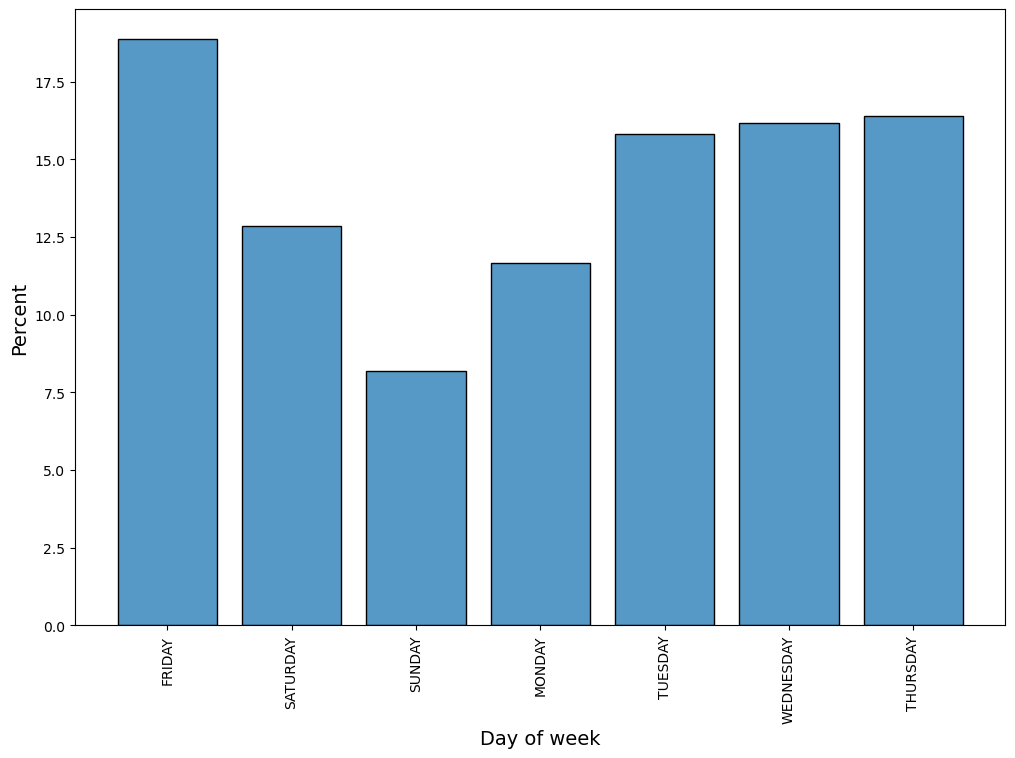

In [20]:
#Se visualiza porcentaje por estado
plt.figure(figsize=(12,8))
sns.histplot(data=tmp_taxis['DAYOFWEEK'], kde=False,  stat="percent", edgecolor='black', discrete=True, shrink=.8)
plt.xlabel('Day of week', fontsize=14)
plt.ylabel('Percent', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

The number of services per state per month is displayed

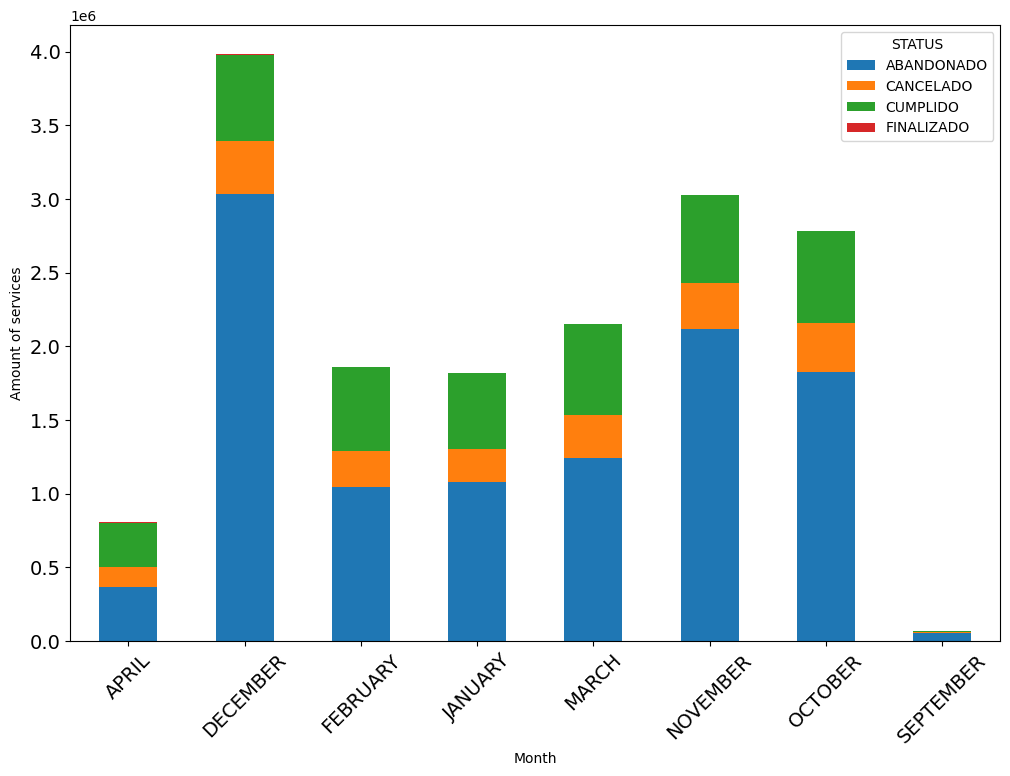

In [21]:
tmp_taxis.groupby(['MONTH','STATUS'])['ID'].count().unstack('STATUS').plot(kind='bar',stacked=True, fontsize=14, xlabel="Month", ylabel="Amount of services", figsize=(12,8), rot=45)
plt.show()

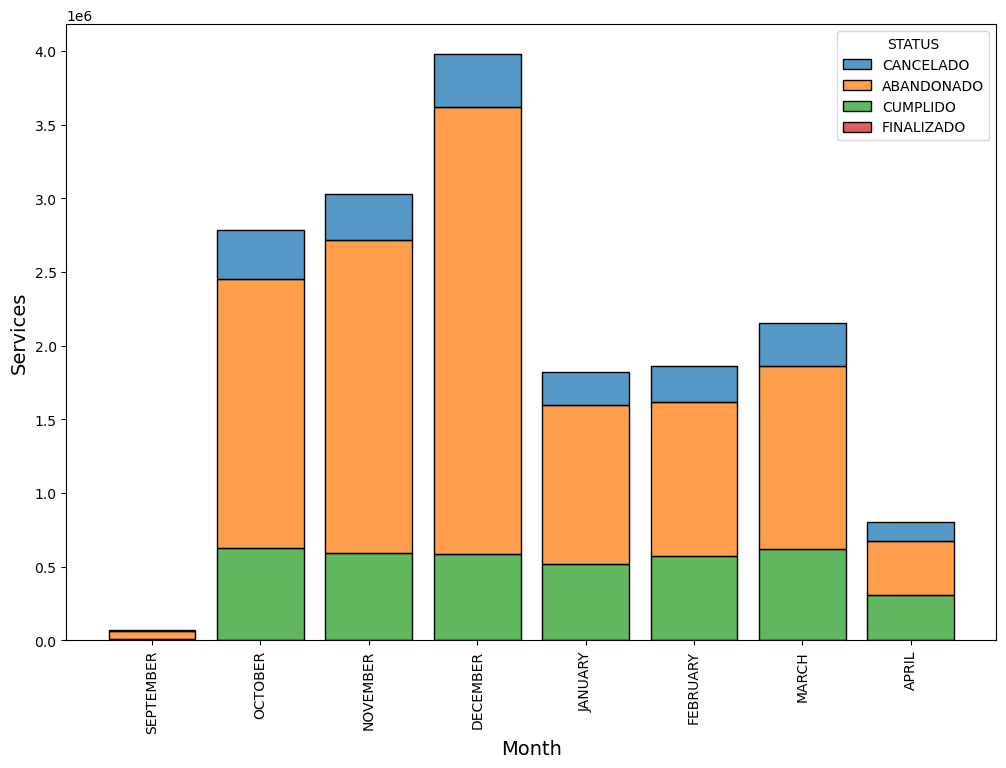

In [22]:
#Se visualiza porcentaje por mes y estado
plt.figure(figsize=(12,8))
sns.histplot(data=tmp_taxis, x='MONTH', hue="STATUS", multiple="stack", shrink=.8)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Services', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

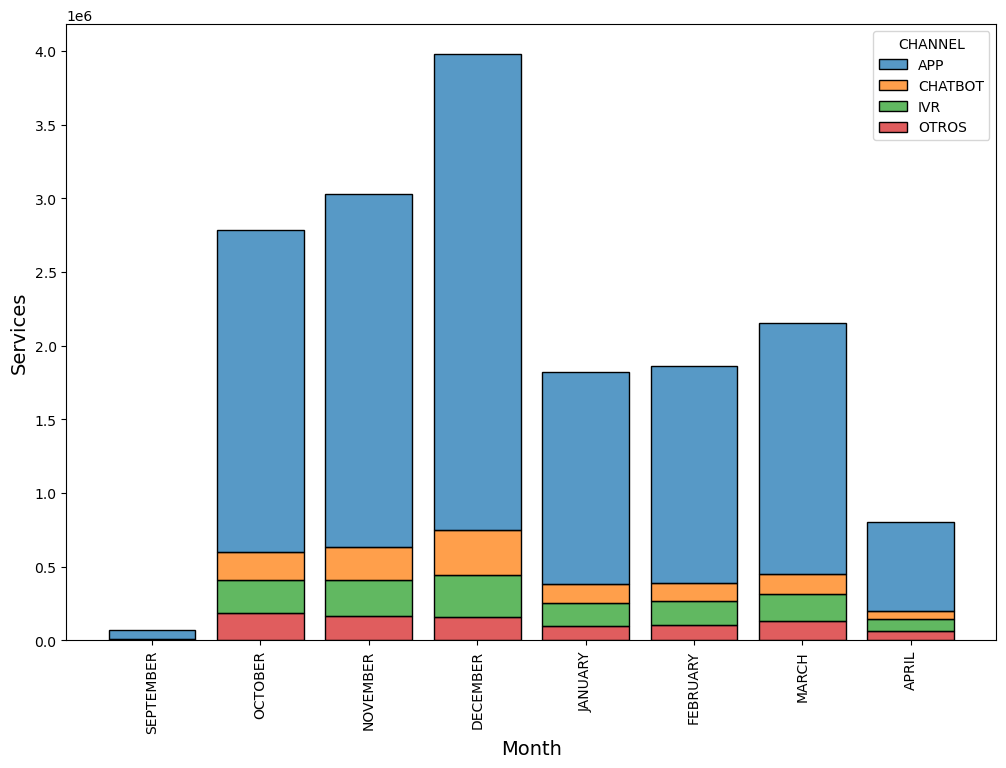

In [23]:
#Se visualiza porcentaje por mes y canal
plt.figure(figsize=(12,8))
sns.histplot(data=tmp_taxis, x='MONTH', hue="CHANNEL", multiple="stack", shrink=.8)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Services', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

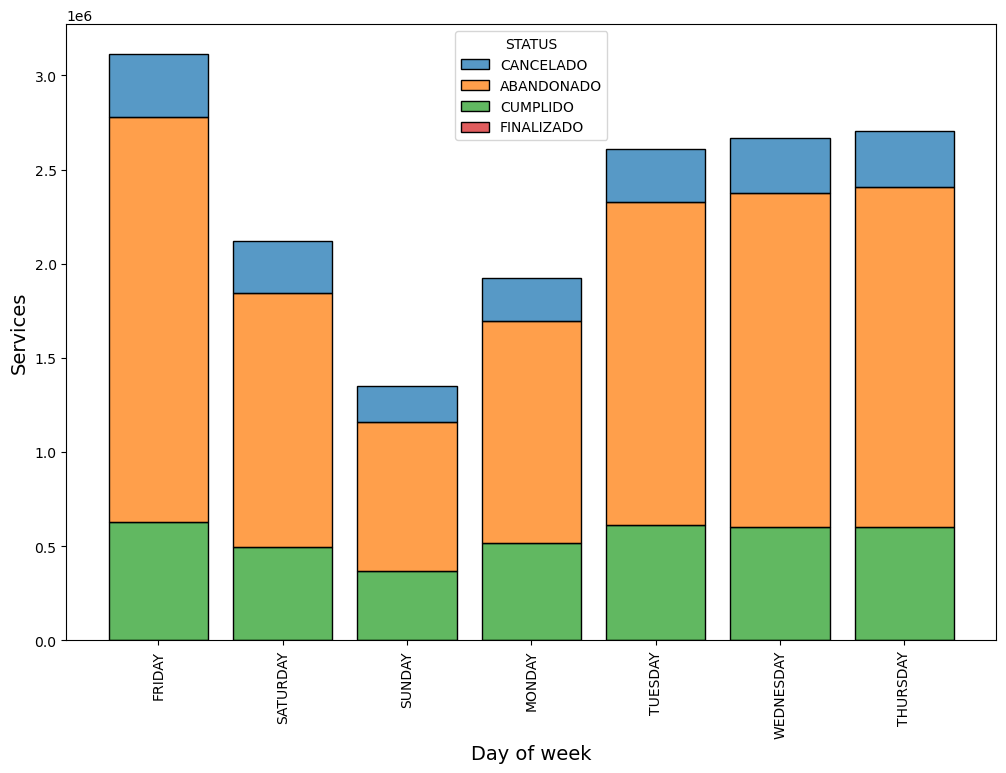

In [24]:
#Se visualiza porcentaje por día de la semana y estado
plt.figure(figsize=(12,8))
sns.histplot(data=tmp_taxis, x='DAYOFWEEK', hue="STATUS", multiple="stack", shrink=.8)
plt.xlabel('Day of week', fontsize=14)
plt.ylabel('Services', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

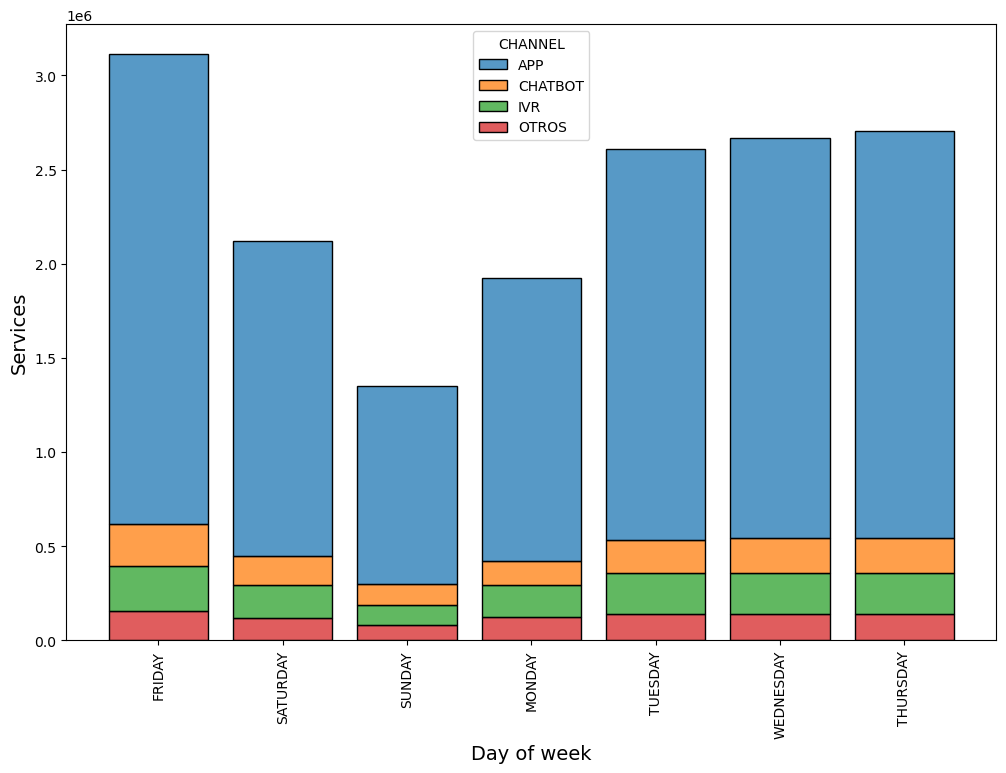

In [25]:
#TODO: delete this block
#df_taxis.groupby(['MONTH','DAYOFWEEK'])['USER'].count().plot(kind='bar',stacked=True, fontsize=14, xlabel="Month, Day of week", ylabel="Amount of services", figsize=(12,8), title="Services by period", rot=45)

#Se visualiza porcentaje por día de la semana y canal
plt.figure(figsize=(12,8))
sns.histplot(data=tmp_taxis, x='DAYOFWEEK', hue="CHANNEL", multiple="stack", shrink=.8)
plt.xlabel('Day of week', fontsize=14)
plt.ylabel('Services', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()


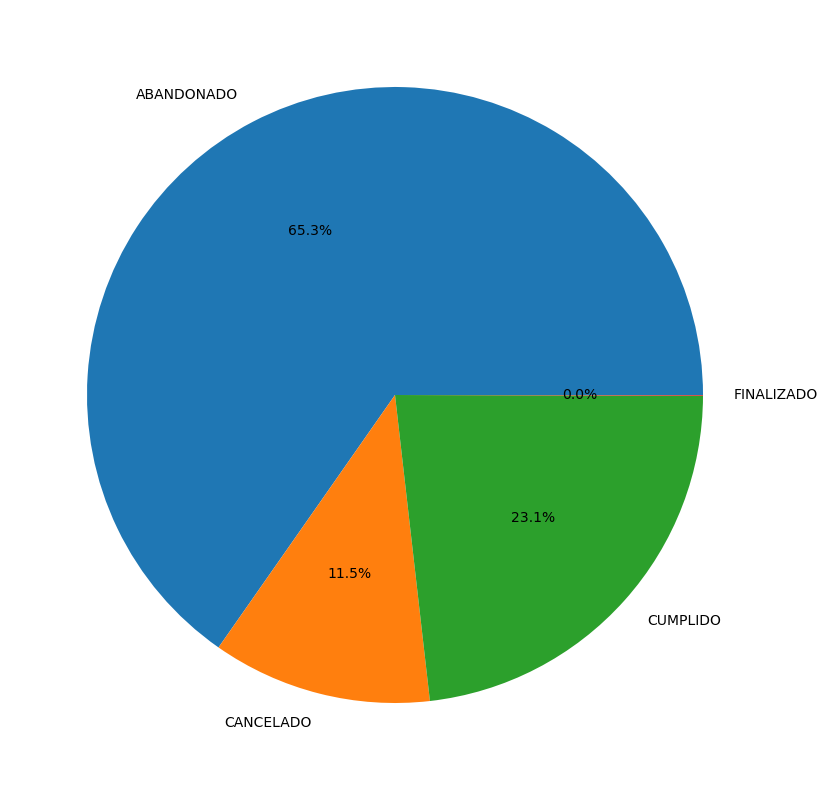

In [26]:
labels = ['ABANDONADO', 'CANCELADO', 'CUMPLIDO', 'FINALIZADO']

fig, ax = plt.subplots(figsize=(12, 8))
ax.pie(tmp_taxis.groupby(['STATUS'])['USER'].count(), labels=labels, autopct='%.1f%%')
#ax.set_title('Status distribution')
plt.tight_layout()
plt.show()

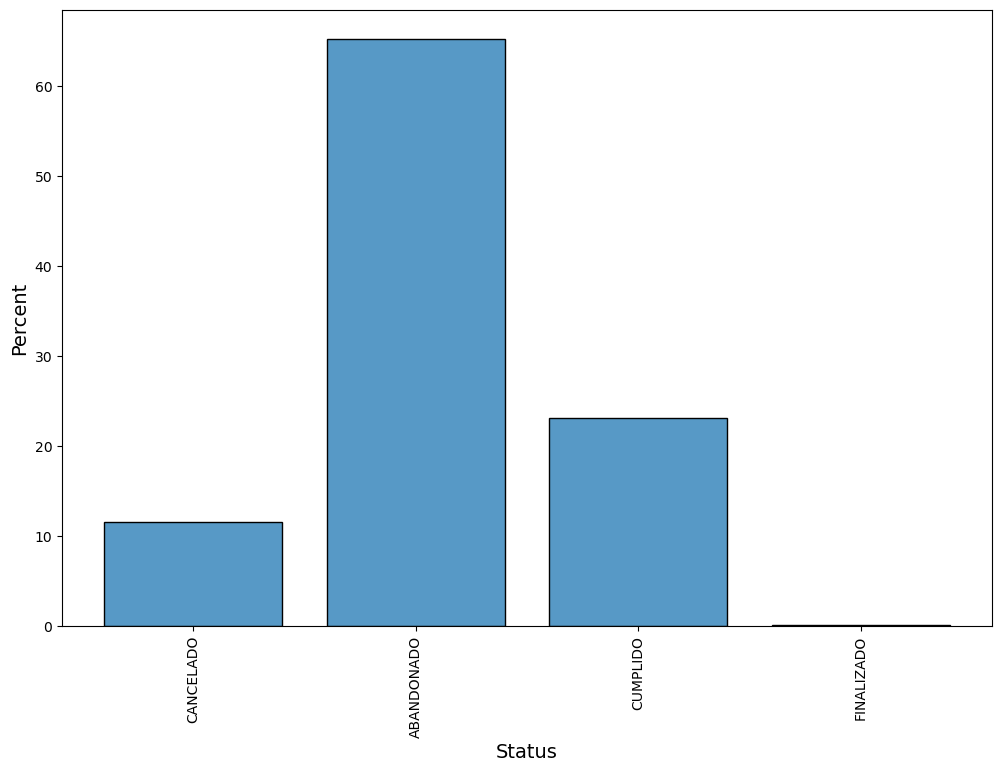

In [27]:
#Se visualiza porcentaje por estado
plt.figure(figsize=(12,8))
sns.histplot(data=tmp_taxis['STATUS'], kde=False,  stat="percent", edgecolor='black', discrete=True, shrink=.8)
plt.xlabel('Status', fontsize=14)
plt.ylabel('Percent', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

In [28]:
tmp_taxis.groupby(['STATUS'])['USER'].count()

STATUS
ABANDONADO    10770020
CANCELADO      1900392
CUMPLIDO       3818711
FINALIZADO        6697
Name: USER, dtype: int64

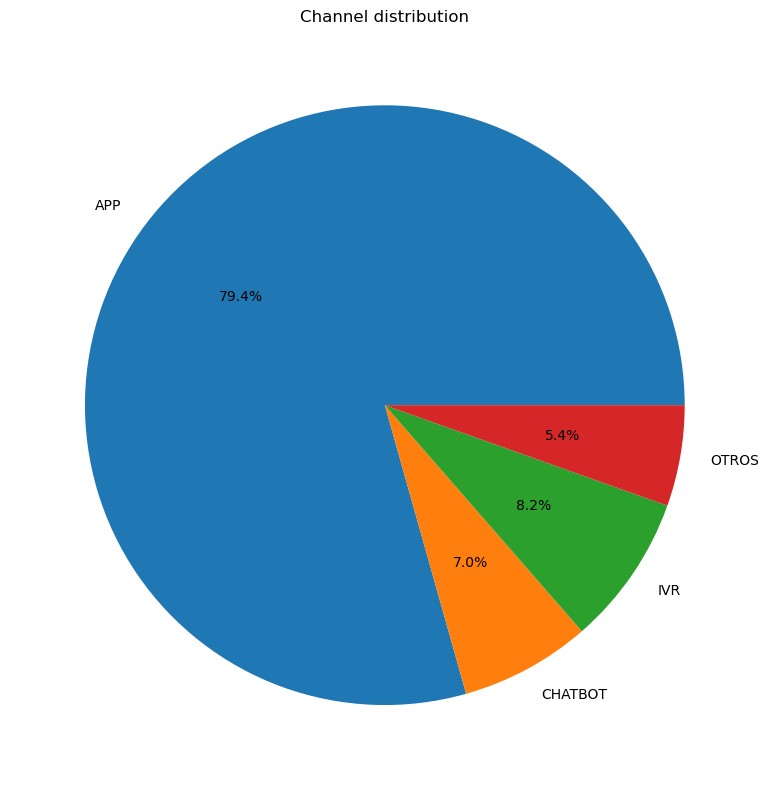

In [29]:
labels = ['APP', 'CHATBOT','IVR','OTROS']

fig, ax = plt.subplots(figsize=(12, 8))
ax.pie(tmp_taxis.groupby(['CHANNEL'])['USER'].count(), labels=labels, autopct='%.1f%%')
ax.set_title('Channel distribution')
plt.tight_layout()
plt.show()

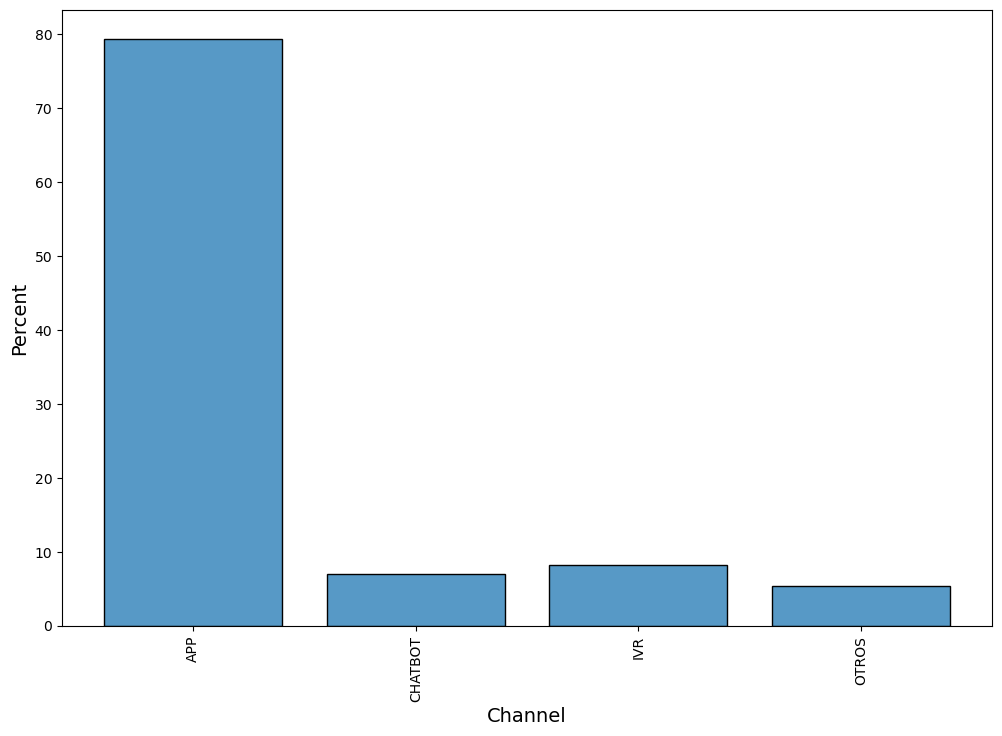

In [30]:
#Se visualiza porcentaje por canal
plt.figure(figsize=(12,8))
sns.histplot(data=tmp_taxis['CHANNEL'], kde=False,  stat="percent", edgecolor='black', discrete=True, shrink=.8)
plt.xlabel('Channel', fontsize=14)
plt.ylabel('Percent', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

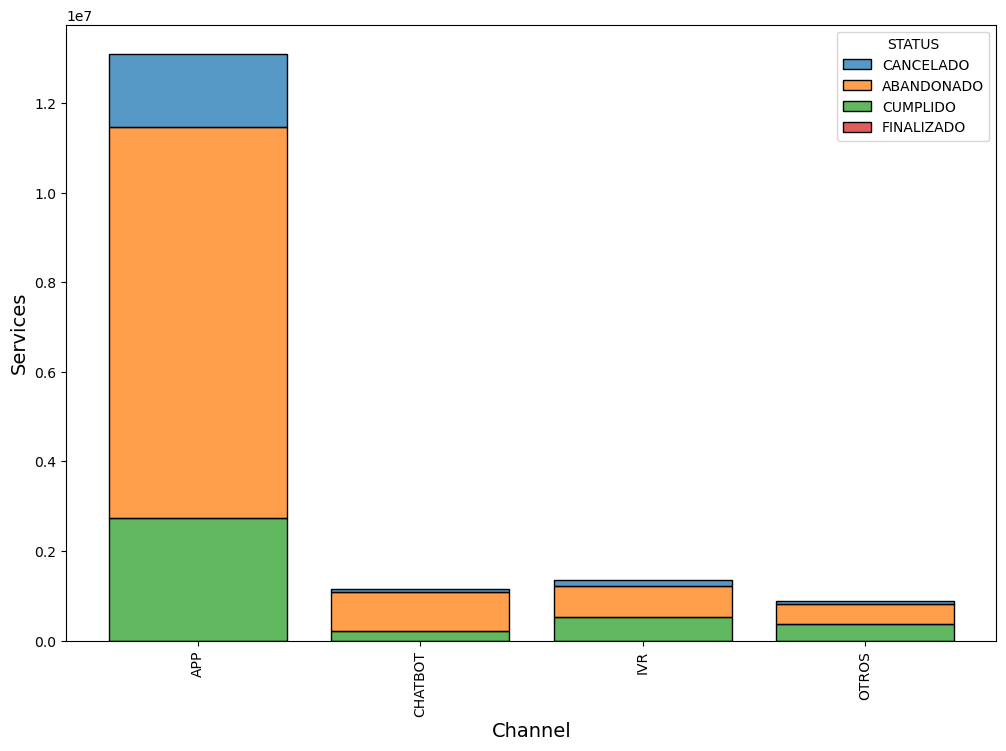

In [31]:
#Se visualiza porcentaje por estado y canales
plt.figure(figsize=(12,8))
sns.histplot(data=tmp_taxis, x='CHANNEL', hue="STATUS", multiple="stack", shrink=.8)
plt.xlabel('Channel', fontsize=14)
plt.ylabel('Services', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

In [32]:
tmp_taxis.groupby(['CHANNEL'])['USER'].count()

CHANNEL
APP        13092824
CHATBOT     1160887
IVR         1344942
OTROS        897167
Name: USER, dtype: int64

In [33]:
tmp_taxis.groupby(['CHANNEL','STATUS'])['USER'].count()

CHANNEL  STATUS    
APP      ABANDONADO    8738028
         CANCELADO     1618602
         CUMPLIDO      2733414
         FINALIZADO       2780
CHATBOT  ABANDONADO     882912
         CANCELADO       70930
         CUMPLIDO       206473
         FINALIZADO        572
IVR      ABANDONADO     691201
         CANCELADO      134515
         CUMPLIDO       516868
         FINALIZADO       2358
OTROS    ABANDONADO     457879
         CANCELADO       76345
         CUMPLIDO       361956
         FINALIZADO        987
Name: USER, dtype: int64

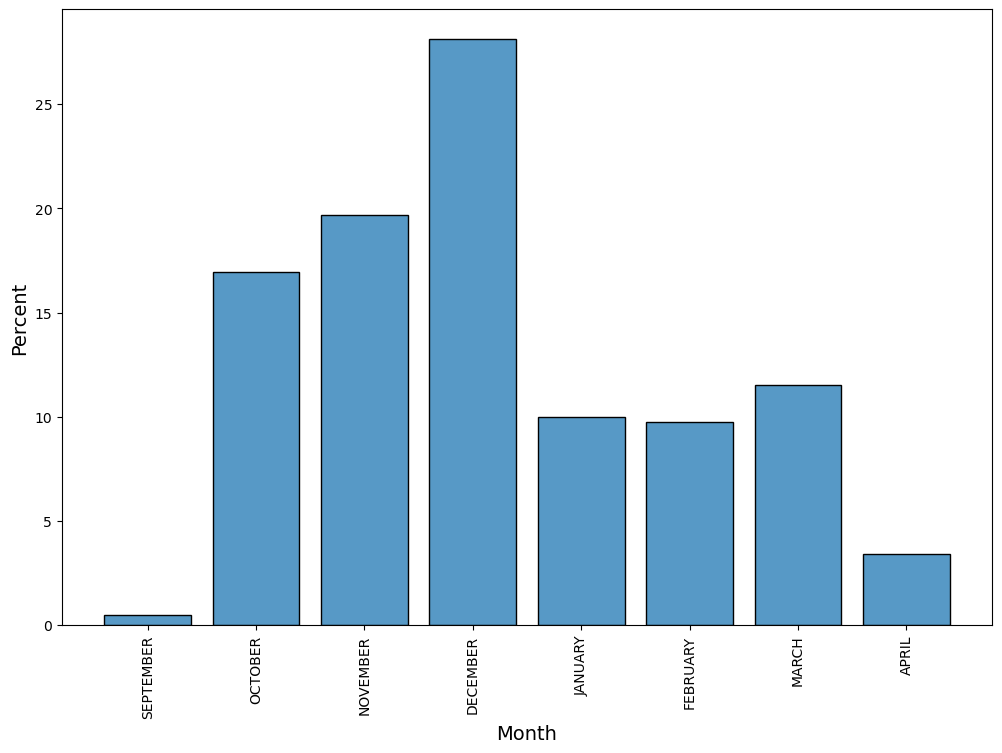

In [34]:
#TODO: delete this block
#tmp_taxis[tmp_taxis['STATUS']=='ABANDONADO'].groupby(['MONTH'])['USER'].count().plot(kind='bar',stacked=True, fontsize=14, xlabel="Month", ylabel="Amount of services", figsize=(12,8), title="Services per month", rot=45)

#Se visualiza porcentaje por estado
plt.figure(figsize=(12,8))
sns.histplot(data=tmp_taxis[tmp_taxis['STATUS']=='ABANDONADO']['MONTH'], stat="percent", edgecolor='black', discrete=True, shrink=.8)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Percent', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

In [35]:
#TODO: delete this block
tmp_taxis.groupby(['MONTH'])['USER'].count()

MONTH
APRIL         805306
DECEMBER     3981620
FEBRUARY     1861559
JANUARY      1817650
MARCH        2151237
NOVEMBER     3026444
OCTOBER      2784538
SEPTEMBER      67466
Name: USER, dtype: int64

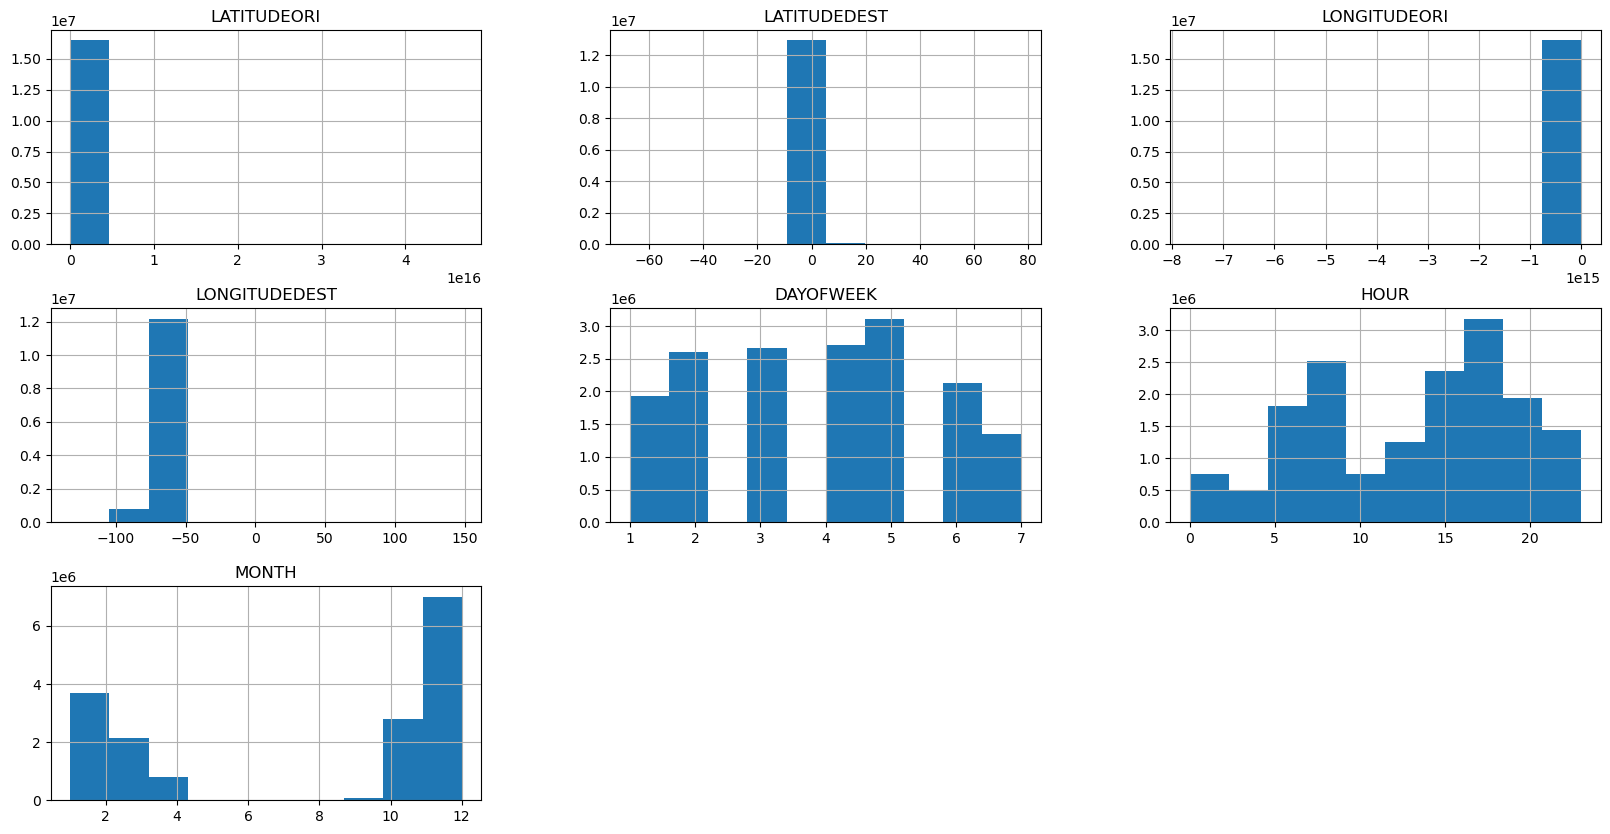

In [36]:
df_taxis.loc[:,['LATITUDEORI','LATITUDEDEST','LONGITUDEORI','LONGITUDEDEST','DAYOFWEEK','HOUR','MONTH']].hist(figsize=(20,10))
plt.show()

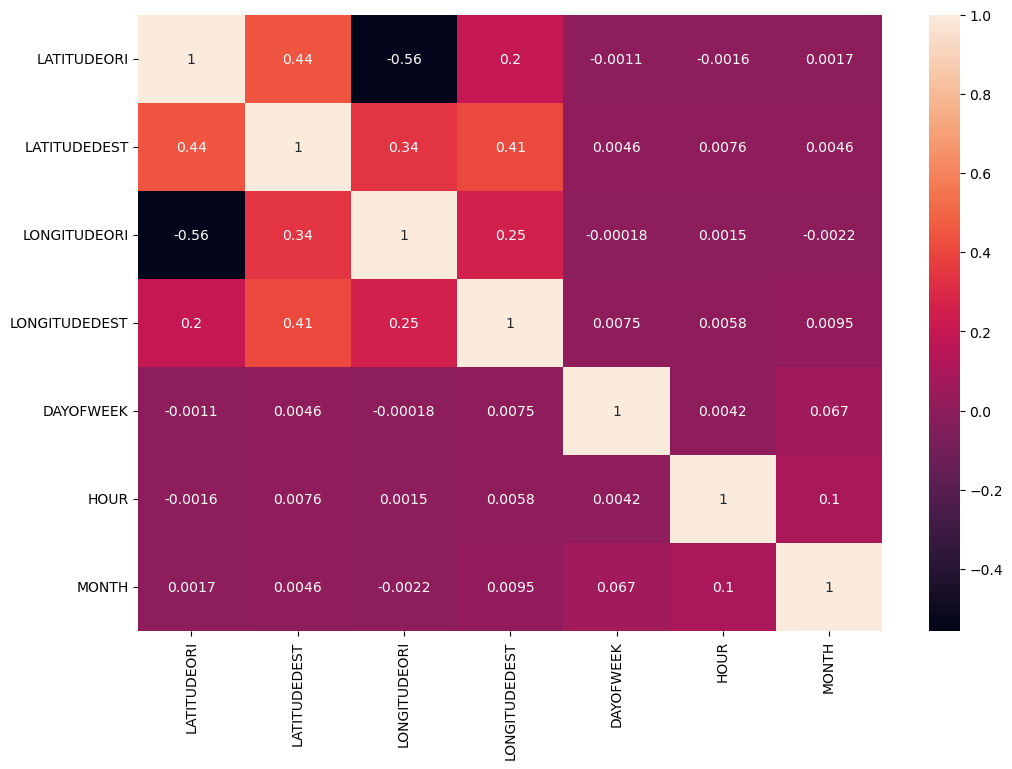

In [37]:
plt.figure(figsize=(12,8))
sns.heatmap(df_taxis.loc[:,['LATITUDEORI','LATITUDEDEST','LONGITUDEORI','LONGITUDEDEST','DAYOFWEEK','HOUR','MONTH']].corr(method='pearson'),annot=True)
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


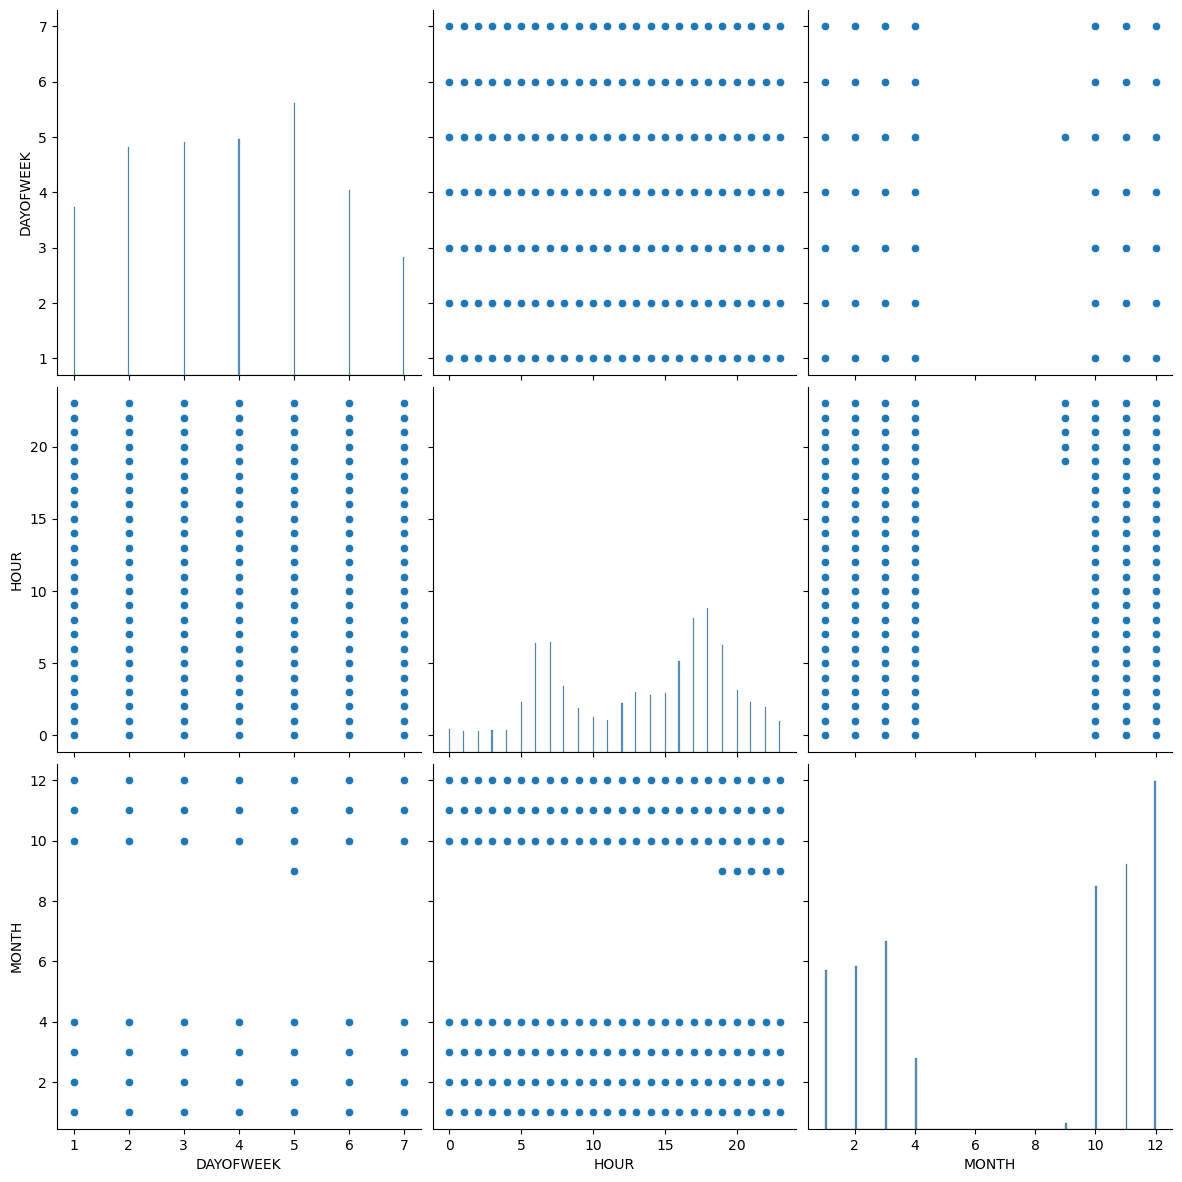

In [38]:
#Se presenta un gráfico general de los datos
sns.pairplot(df_taxis.loc[:,['DAYOFWEEK','HOUR','MONTH']], height=4)
plt.show()

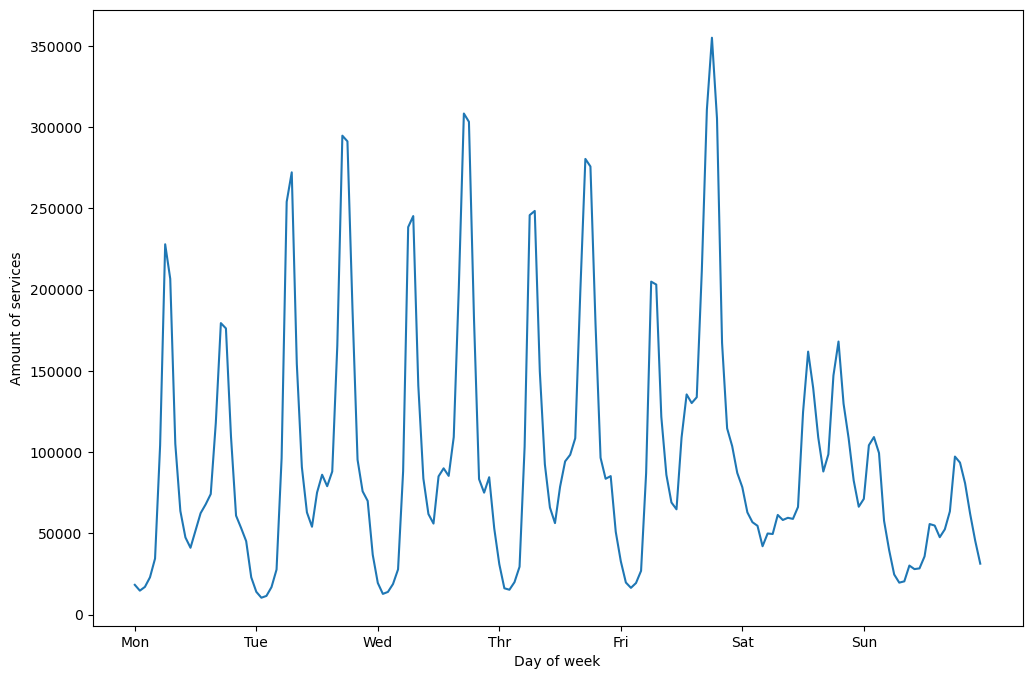

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
s_taxis = df_taxis.groupby(['DAYOFWEEK','HOUR'])['DATE'].count()
s_taxis.plot(ax=ax)
_ = ax.set(
    #title="Number of services per week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thr", "Fri", "Sat", "Sun"],
    xlabel="Day of week",
    ylabel="Amount of services",
)

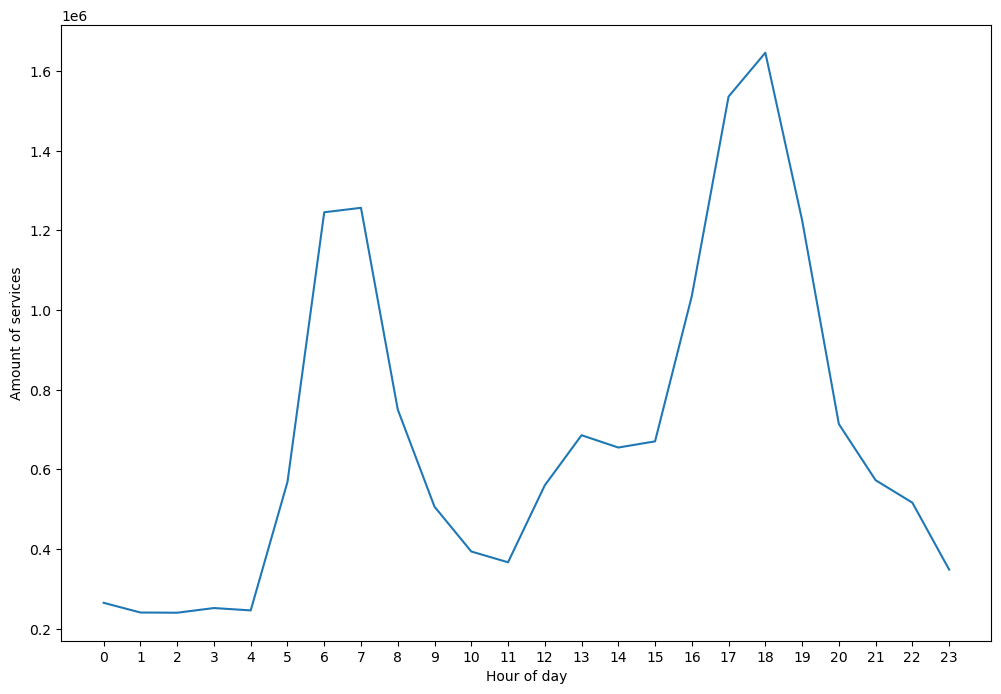

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))
s_taxis = df_taxis.groupby(['HOUR'])['DATE'].count()
s_taxis.plot(ax=ax)
_ = ax.set(
    #title="Number of services per hour",
    xticks=[i for i in range(24)],
    xticklabels=[i for i in range(24)],
    xlabel="Hour of day",
    ylabel="Amount of services",
)

## Display of filtered data

The dataset is filtered with the values to be used: 6 weeks for training and 1 week for the test

In [41]:
df_taxis = df_taxis[ (pd.to_datetime(df_taxis['COMPLETEDATE'], format=FORMAT_COMPLETE_DATE) >= last_date_dataset) & (pd.to_datetime(df_taxis['COMPLETEDATE'], format=FORMAT_COMPLETE_DATE) <= first_date_dataset) ]
df_taxis = df_taxis.sort_values(by=['COMPLETEDATE','USER'])
print(f"The dataset is restricted from date:{last_date_dataset} - to date:{first_date_dataset}")

The dataset is restricted from date:2023-01-27 00:00:00 - to date:2023-03-17 00:00:00


DataFrame data is displayed in a histogram to analyze the data

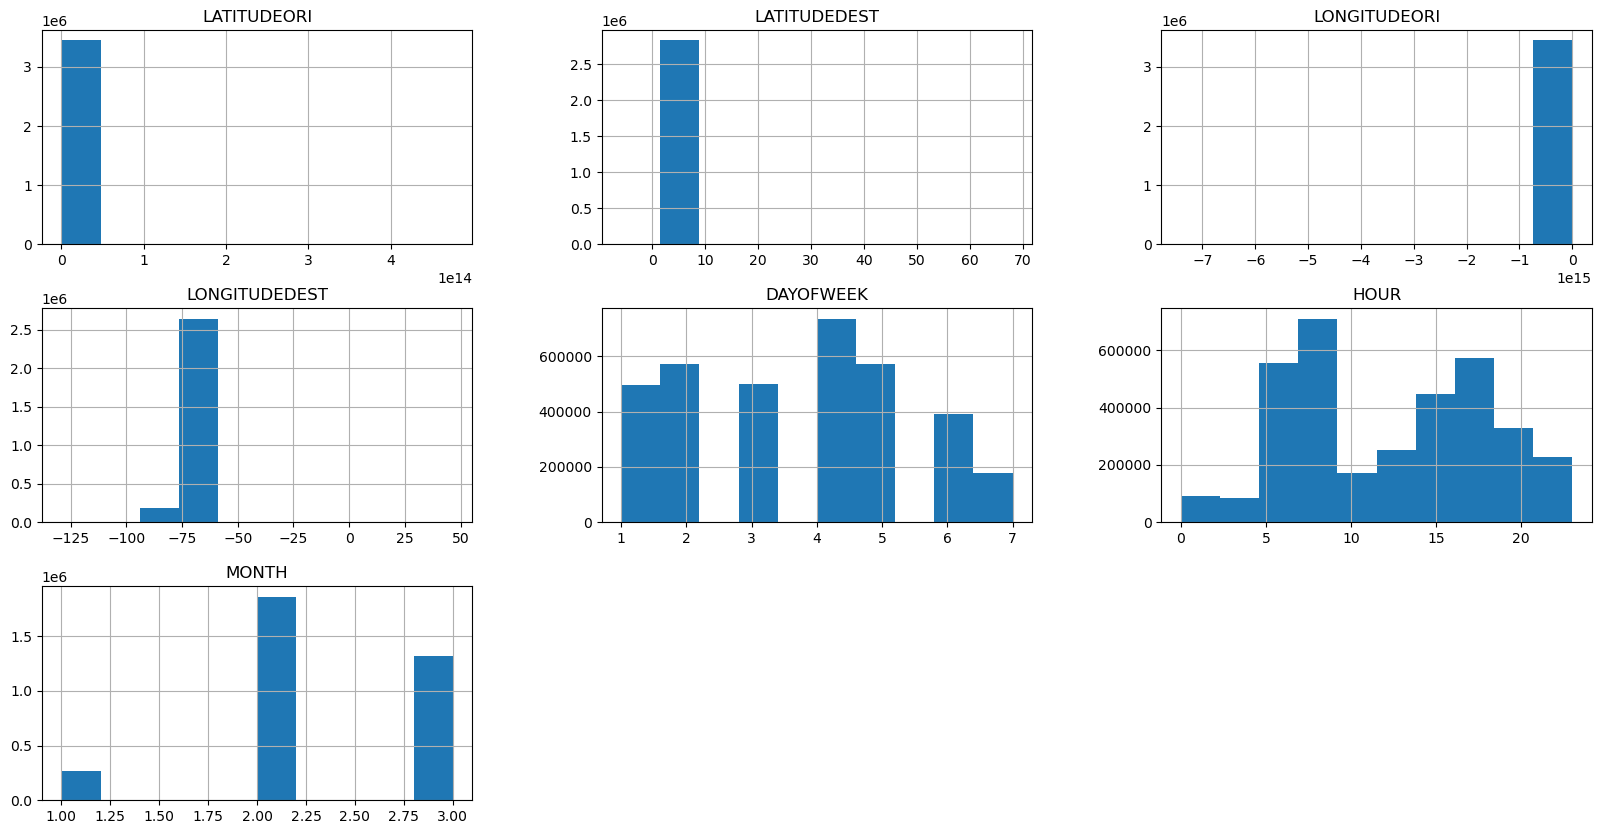

In [42]:
df_taxis.loc[:,['LATITUDEORI','LATITUDEDEST','LONGITUDEORI','LONGITUDEDEST','DAYOFWEEK','HOUR','MONTH']].hist(figsize=(20,10))
plt.show()

The number of services per channel per state is displayed

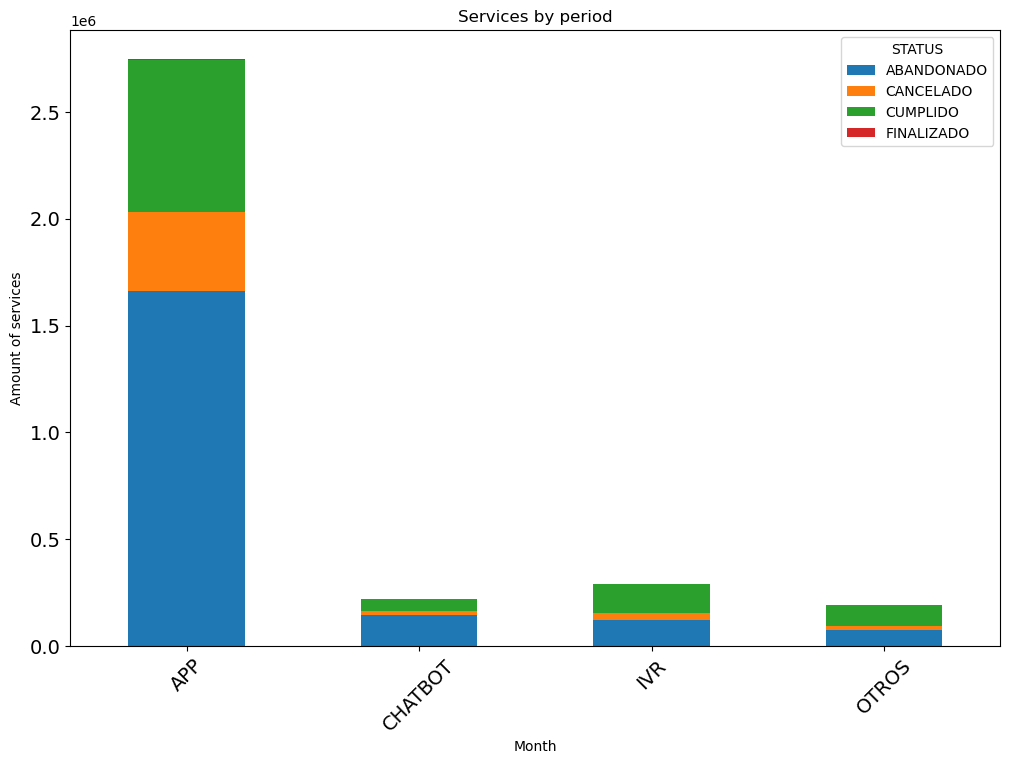

In [43]:
df_taxis.groupby(['CHANNEL','STATUS'])['ID'].count().unstack('STATUS').plot(kind='bar',stacked=True, fontsize=14, xlabel="Month", ylabel="Amount of services", figsize=(12,8), title="Services by period", rot=45)
plt.show()

In [44]:
#TODO: delete this block
df_taxis.groupby(['DATE','DAYOFWEEK'])['USER'].count()

DATE        DAYOFWEEK
2023-01-27  5             69358
2023-01-28  6             41837
2023-01-29  7             19730
2023-01-30  1             67890
2023-01-31  2             71501
2023-02-01  3             84182
2023-02-02  4            236126
2023-02-03  5            118470
2023-02-04  6             62444
2023-02-05  7             25926
2023-02-06  1             64263
2023-02-07  2             61388
2023-02-08  3             69553
2023-02-09  4             67856
2023-02-10  5             72424
2023-02-11  6             39490
2023-02-12  7             18299
2023-02-13  1             48698
2023-02-14  2             35014
2023-02-15  3             33613
2023-02-16  4             81271
2023-02-17  5             76700
2023-02-18  6             56590
2023-02-19  7             22191
2023-02-20  1             60240
2023-02-21  2             85748
2023-02-22  3             34823
2023-02-23  4             60379
2023-02-24  5             71686
2023-02-25  6             40284
2023-02-26  7     

- Channels are limited to: APP, RECEPCION, CHAT_BOT_659, IVR and CALLE

- States are limited to: ABANDONADO, CUMPLIDO, CANCELADO and FINALIZADO

In [45]:
df_taxis = df_taxis[(df_taxis["CHANNEL"]=="APP") ]#| (df_taxis["CHANNEL"]=="RECEPCION") | (df_taxis["CHANNEL"]=="CHAT_BOT_659") | (df_taxis["CHANNEL"]=="IVR") | (df_taxis["CHANNEL"]=="CALLE")]
df_taxis = df_taxis[(df_taxis["STATUS"]=="ABANDONADO") | (df_taxis["STATUS"]=="CUMPLIDO") | (df_taxis["STATUS"]=="CANCELADO") | (df_taxis["STATUS"]=="FINALIZADO")]

In [46]:
df_taxis.drop(labels='STATUS', axis=1)

,ID,CITY,USER,LATITUDEORI,LATITUDEDEST,LONGITUDEORI,LONGITUDEDEST,CHANNEL,COMPLETEDATE,DATE,DAYOFWEEK,HOUR,MONTH
11416766,91623237,11001,9633983.0,4.677175,4.734961,-74.048048,-74.025712,APP,2023-01-27 00:00:04,2023-01-27,5,0,1
11416767,91623238,11001,8495182.0,4.691108,4.696928,-74.076157,-74.081983,APP,2023-01-27 00:00:07,2023-01-27,5,0,1
11416769,91623240,11001,8121136.0,4.679135,4.708913,-74.053129,-74.137175,APP,2023-01-27 00:00:19,2023-01-27,5,0,1
11416768,91623239,11001,11126612.0,4.637783,4.630673,-74.156330,-74.159206,APP,2023-01-27 00:00:19,2023-01-27,5,0,1
11416770,91623241,11001,8218555.0,4.584267,4.500195,-74.091763,-74.109510,APP,2023-01-27 00:00:29,2023-01-27,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14867706,95002058,11001,11105533.0,4.709767,4.675948,-74.112223,-74.092874,APP,2023-03-16 23:59:11,2023-03-16,4,23,3
14867707,95002059,11001,8402040.0,4.638548,4.641556,-74.161491,-74.165568,APP,2023-03-16 23:59:20,2023-03-16,4,23,3
14867709,95002061,11001,11282492.0,4.569968,4.574290,-74.145076,-74.124000,APP,2023-03-16 23:59:34,2023-03-16,4,23,3
14867710,95002062,11001,8051106.0,4.646117,4.648542,-74.086899,-74.085399,APP,2023-03-16 23:59:52,2023-03-16,4,23,3


Correlations between variables are displayed

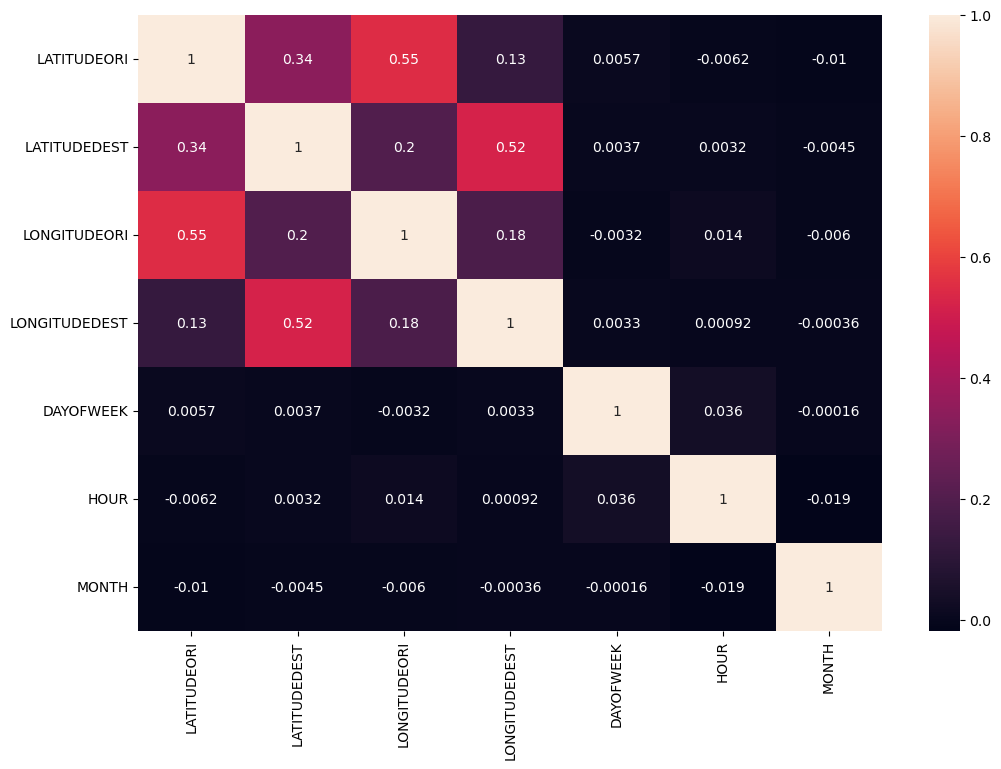

In [47]:
plt.figure(figsize=(12,8))
sns.heatmap(df_taxis.loc[:,['LATITUDEORI','LATITUDEDEST','LONGITUDEORI','LONGITUDEDEST','DAYOFWEEK','HOUR','MONTH']].corr(method='pearson'),annot=True)
plt.show()

A histogram is displayed with the number of services per state

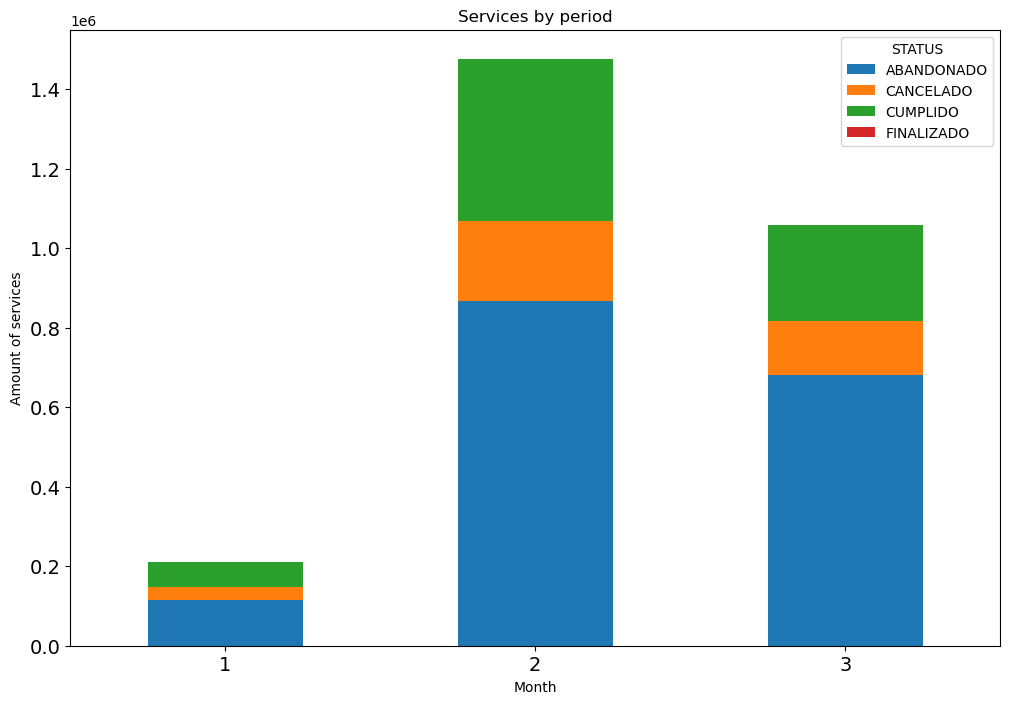

In [48]:
df_taxis.groupby(['MONTH','STATUS'])['ID'].count().unstack('STATUS').plot(kind='bar',stacked=True, fontsize=14, xlabel="Month", ylabel="Amount of services", figsize=(12,8), title="Services by period", rot=0)
plt.show()

The number of services per status is displayed

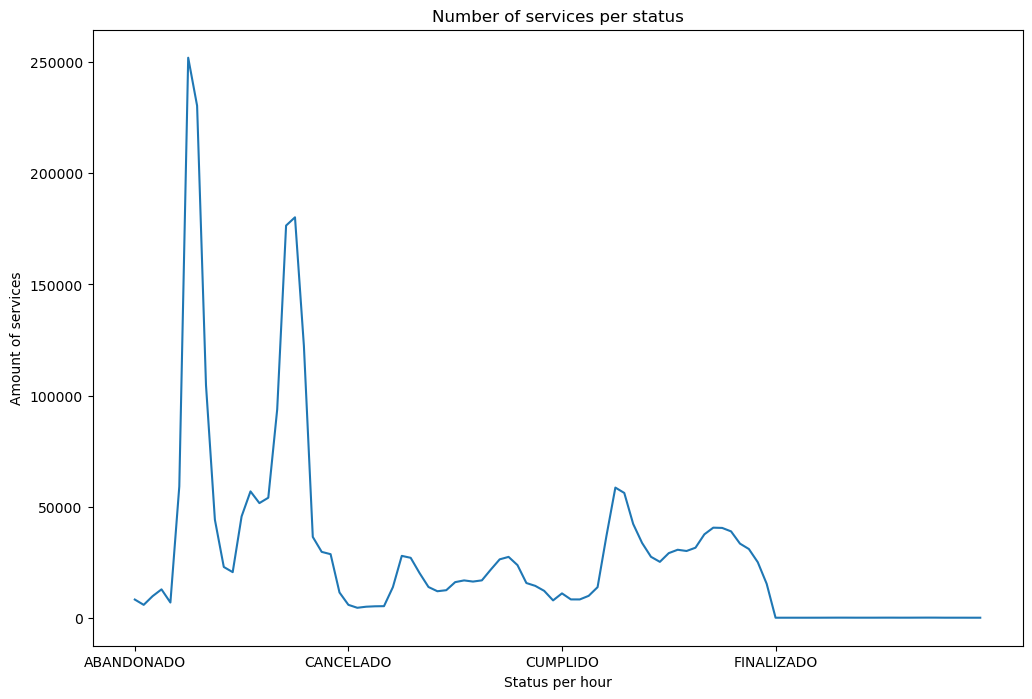

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))
s_taxis = df_taxis.groupby(['STATUS','HOUR'])['DATE'].count()
s_taxis.plot(ax=ax)
_ = ax.set(
    title="Number of services per status",
    xticks=[i * 24 for i in range(4)],
    xticklabels=["ABANDONADO", "CANCELADO", "CUMPLIDO", "FINALIZADO"],
    xlabel="Status per hour",
    ylabel="Amount of services",
)

Columns that are not useful for the model are deleted and reindex the data frame

In [50]:
df_taxis = df_taxis.drop(columns=["CITY","ID","LATITUDEDEST","LONGITUDEDEST","LATITUDEORI","LONGITUDEORI","COMPLETEDATE","CHANNEL","STATUS","MONTH"])
#Duplicate values are removed from the dataframe and sorted by the most relevant fields
df_taxis = df_taxis.drop_duplicates().sort_values(by=['DATE','USER','DAYOFWEEK','HOUR'])
#The data frame is reindexed again
df_taxis = df_taxis.reset_index(drop=True)
#The data frame is displayed
df_taxis.head(5)

,USER,DATE,DAYOFWEEK,HOUR
0,3564.0,2023-01-27,5,18
1,3598.0,2023-01-27,5,6
2,5174.0,2023-01-27,5,16
3,5174.0,2023-01-27,5,22
4,7004.0,2023-01-27,5,18


Non-recurrent users are removed from the dataset (Recurrent users are those who took at least 6 services on the same day and at the same time during the last 8 previous weeks)

In [51]:
def recurrentUsers(p_user, df_tx, training_date):
    current_week = training_date.isoweekday()
    first_time = pd.to_datetime(training_date, format=FORMAT_DATE)
    last_time = first_time + timedelta(weeks=-TRAIN_WEEK)
    for hour in range(HOURS_OF_DAY):
      df_rec = df_tx[ (df_tx["USER"] == p_user) & (df_tx["DAYOFWEEK"] == current_week) & (df_tx['DATE'].astype(str) >= last_time.strftime(FORMAT_DATE)) & (df_tx['DATE'].astype(str) <= first_time.strftime(FORMAT_DATE)) & (df_tx['HOUR'] == hour) ]
      total = len(df_rec)
      if total >= WEEKS_RECURRENT:
        return df_tx[ (df_tx["USER"] == p_user) ]
    return pd.DataFrame({})

In [52]:
def processingRecurrentUsers(data_taxis):
    start_time = time.perf_counter()
    df_user = data_taxis.loc[:,['USER']].copy()
    df_new = pd.DataFrame({})
    total_user, removed_users, count, user_array = 0, 0, 0, []
    list_users = df_user.value_counts().index.to_list()
    print(f"Users to process {len(list_users)}")

    for user in list_users:
        count += 1
        user_array.append(user[0])
        if count % 10000 == 0 or count >= len(list_users):
            list_result = []
            args = [(user, data_taxis[ (data_taxis["USER"] == user) ], DATE_START_TRAINIG) for user in user_array]
            with Pool() as pool:
                list_result = pool.starmap(recurrentUsers, args)
            for df in list_result:
                if len(df) > 0:
                    total_user += 1
                else:
                    removed_users += 1
                df_new = pd.concat([df_new, df])
            user_array = []
            finish_time = time.perf_counter()
            print(f"Processing first {count} users of {len(df_user.value_counts().index.to_list())-count}, total recurents users: {total_user}, removed users {removed_users} in {format(finish_time-start_time)} seconds")
        if count >= 80000:
            break
    finish_time = time.perf_counter()
    print(f"Program finished in {format(finish_time-start_time)} seconds, total recurents users: {total_user}, removed users {removed_users} total rows {len(df_new)}")
    return df_new

Processing recurrent users

In [ ]:
df_taxis = processingRecurrentUsers(df_taxis)

Users to process 214190
Processing first 10000 users of 204190, total recurents users: 894, removed users 9106 in 119.10554483199996 seconds
Processing first 20000 users of 194190, total recurents users: 951, removed users 19049 in 243.1541488219999 seconds
Processing first 30000 users of 184190, total recurents users: 968, removed users 29032 in 364.91956102200004 seconds


The number of services per week is displayed

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
s_taxis = df_taxis.groupby(['DAYOFWEEK','HOUR'])['DATE'].count()
s_taxis.plot(ax=ax)
_ = ax.set(
    title="Number of services per week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thr", "Fri", "Sat"],
    xlabel="Day of week",
    ylabel="Amount of services",
)

The number of services per hour is displayed

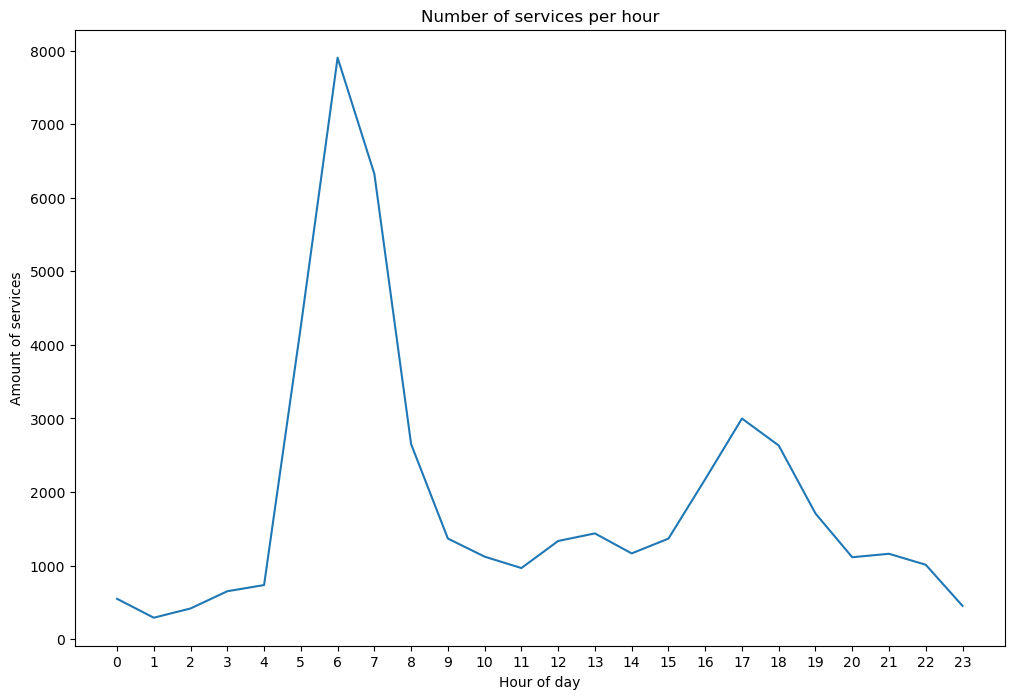

In [55]:
fig, ax = plt.subplots(figsize=(12, 8))
s_taxis = df_taxis.groupby(['HOUR'])['DATE'].count()
s_taxis.plot(ax=ax)
_ = ax.set(
    title="Number of services per hour",
    xticks=[i for i in range(24)],
    xticklabels=[i for i in range(24)],
    xlabel="Hour of day",
    ylabel="Amount of services",
)

### DATA VISUALIZATION

* Scatter plot of the variables
* Graph of distribution of variables (Low distribution, Low prediction)
* Correlation graphs (Heat map)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


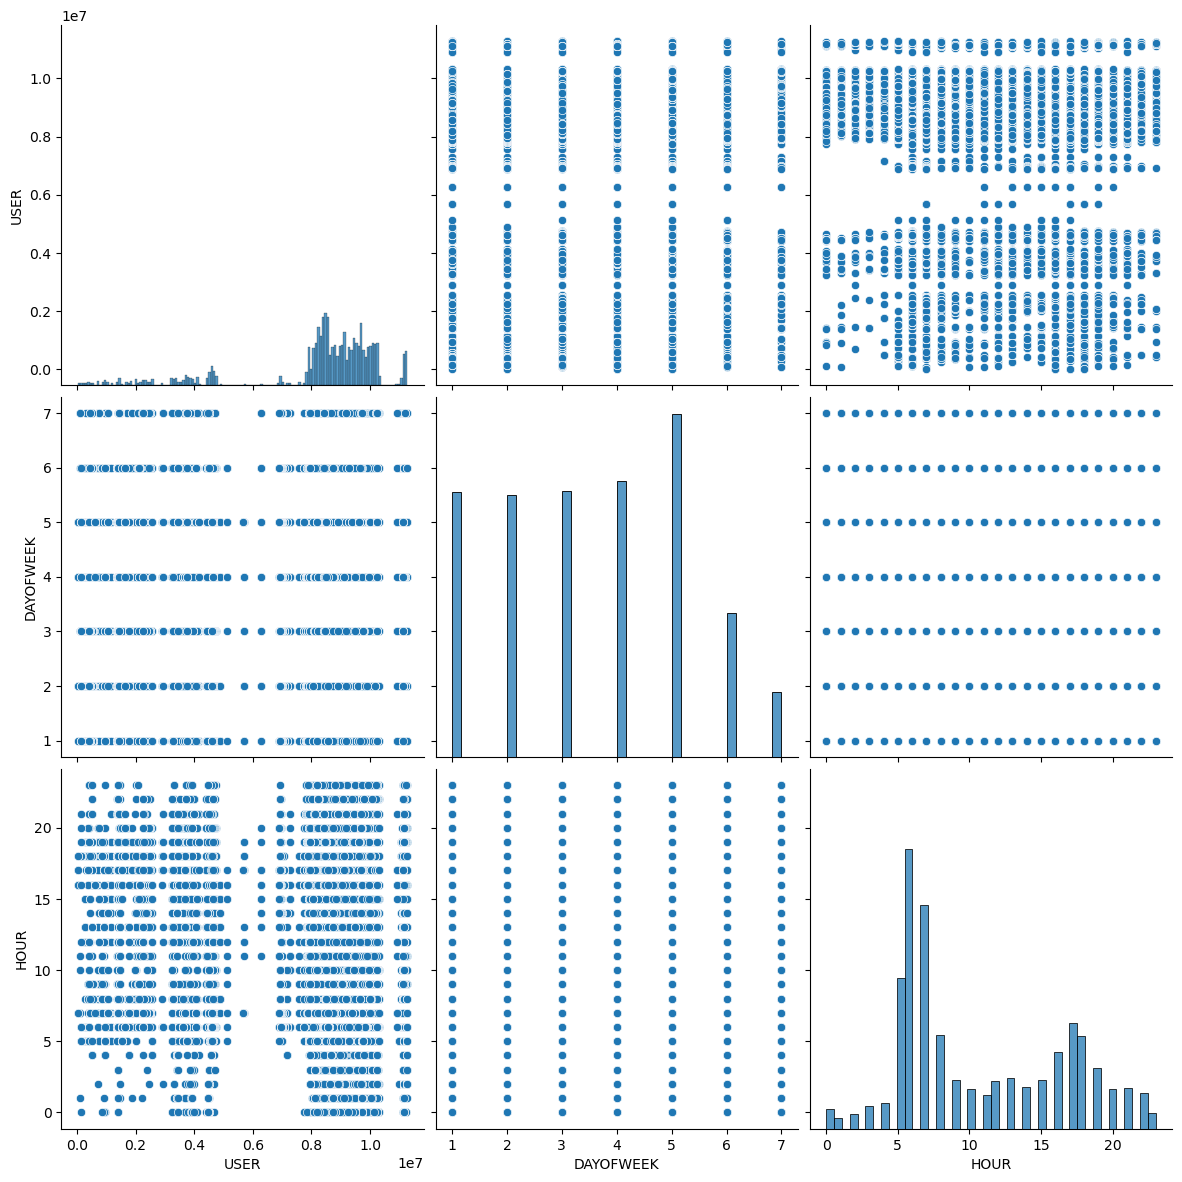

In [56]:
#Se presenta un gráfico general de los datos
sns.pairplot(df_taxis, height=4)
plt.show()

df_taxisThe correlation matrix is displayed

In [57]:
corr_matrix = df_taxis.loc[:,['DAYOFWEEK','HOUR']].corr()
corr_matrix

,DAYOFWEEK,HOUR
DAYOFWEEK,1.000000,0.043783
HOUR,0.043783,1.000000


The relationship between variables in the data are displayed

Text(0.5, 58.7222222222222, 'X')

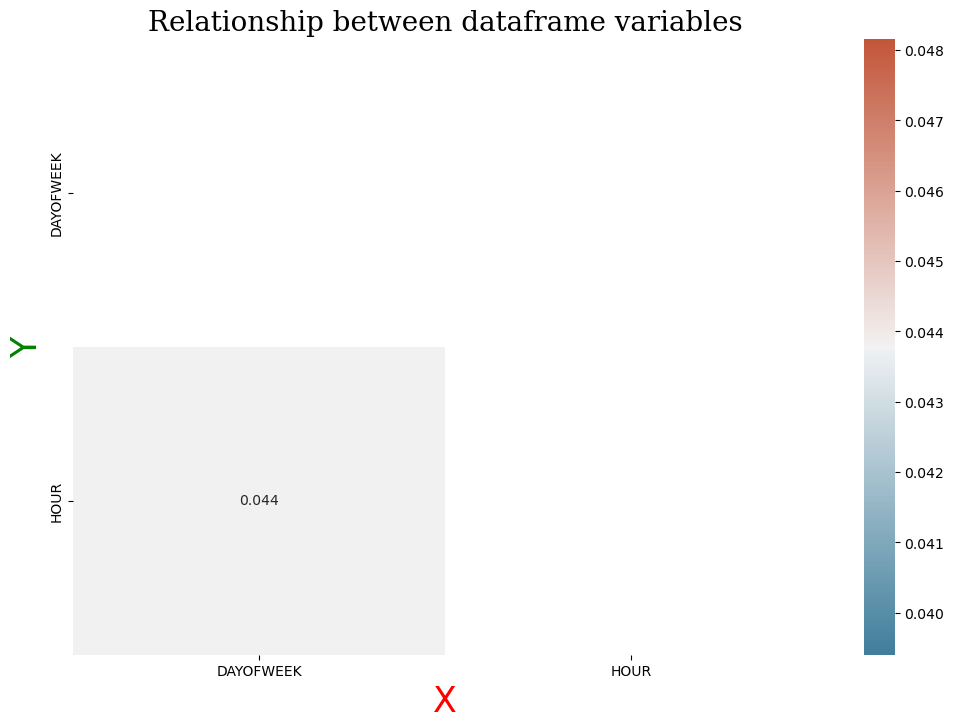

In [58]:
f, ax = plt.subplots(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, mask = mask, cmap=cmap )
plt.title('Relationship between dataframe variables',fontsize=20,fontname='serif')
plt.ylabel('Y', color='green', fontsize=25)
plt.xlabel('X', color='Red', fontsize=25)

Function to train the model and predict with test values

In [59]:
def predictModel(model, X_train, y_train, X_test):
    #A continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para pruebas
    y_pred = model.predict(X_test)
    #Se crean las probabilidades para pruebas
    y_prob = model.predict_proba(X_test)
    return model, y_pred, y_prob

Function that evaluate the K-neighbors model

In [60]:
def knnModel(X_train, y_train, X_test):
    #Se aplica el modelo de K vecinos
    model = KNeighborsClassifier(n_neighbors=2)#, metric='euclidean',leaf_size=1, p=1, weights='uniform')
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Multi-layer Perceptron model

In [61]:
def mlpModel(X_train, y_train, X_test):
    #Se aplica el modelo de perceptrones multi capa
    model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,30, 30), random_state=1,learning_rate_init=0.001,max_iter=5000)
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Perceptron model

In [62]:
def perModel(X_train, y_train, X_test):
    #Se aplica el modelo de perceptrones multi capa
    model = Perceptron(eta0=0.1, n_iter_no_change=10, random_state=1)
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Logistic Regression model

In [63]:
def lrModel(X_train, y_train, X_test):
    #Se aplica el modelo de de regesión logística
    model = LogisticRegression(random_state = 1)
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Random Forest model

In [64]:
def rfcModel(X_train, y_train, X_test):
    #Se aplica el modelo de los arboles aleatorios
    model = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=200, class_weight="balanced")
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Support Vector Machine model

In [65]:
def svcModel(X_train, y_train, X_test):
    #Se aplica el modelo de máquina de soporte de vectores
    model = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0, class_weight='balanced')#, class_weight='balanced'
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Decision Tree model

In [66]:
def dtcModel(X_train, y_train, X_test):
    #Se aplica el modelo de los arboles de desiciones
    model = DecisionTreeClassifier(criterion='gini', max_depth=3, class_weight='balanced')#class_weight={0: 1, 1: 5}
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate Extra Trees Classifier

In [67]:
def etcModel(X_train, y_train, X_test):
    model = ExtraTreesClassifier(n_estimators=1, max_depth=1, min_samples_split=2, random_state=0, class_weight="balanced")
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate Gradient Boosting Classifier, this function supports both binary and multi-class classification

In [68]:
def gbcModel(X_train, y_train, X_test):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate Ada Boost

In [69]:

def abcModel(X_train, y_train, X_test):
    model = AdaBoostClassifier(n_estimators=1,algorithm='SAMME',random_state=0)
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Stochastic Gradient Descent model

In [70]:
def sgdModel(X_train, y_train, X_test,):
    #Se aplica el modelo de gradiente descendente estocástico
    model =SGDClassifier(loss='huber', random_state=1, max_iter=2000, epsilon=0.1)#loss='hinge'
    return predictModel(model, X_train, y_train, X_test)

Function to display the confusion matrix

In [71]:
def confusionMatrix(model, y_test, y_pred):
  plt.rcParams.update({'font.size': 16})
  cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=model.classes_)
  disp.plot()
  plt.show()

Function to calculate a user's probability

In [72]:
def ProbabilisticClassifier(holiday, hour, dayOfWeek, data):
  df_onset = data[ (data['HOLIDAY'] == holiday) & (data['DAYOFWEEK'] == dayOfWeek) & (data['HOUR'] == hour) & (data['SERVICE'] == 1) ]
  total_onset = len(df_onset)
  if total_onset > 0:
    return total_onset / TRAIN_WEEK
  else:
    return 0

Function to evaluate the probabilistic model

In [73]:
def probabilisticModel(data, date_predict):
    co_holidays = holidays.CO()
    threshold = 0.7
    array_result = []
    array_prob = []
    for hour in range(HOURS_OF_DAY):
        result = ProbabilisticClassifier(1 if co_holidays.get(date_predict) != None else 0, hour, date_predict.isoweekday(), data)
        array_prob.append(round(result,2))
        array_result.append(1 if result >= threshold else 0)
    return array_result, array_prob

Function to validate if it contains all data in 0

In [74]:
def existAllZero(arr):
    if len(arr)>0:
        for value in arr:
            if value != 0:
                return False
    return True

Function to return the name of the models

In [75]:
def modelName(model_type):
    if model_type == 'LR':
        return 'Logistic regression'
    elif model_type == 'KNN':
        return 'Kneighbors'
    elif model_type == 'MLP':
        return 'Multilayer perceptron'
    elif model_type == 'RFC':
        return 'Random forest'
    elif model_type == 'SVC':
        return 'Support vector'
    elif model_type == 'SGD':
        return 'Gradient descent stochastic'
    elif model_type == 'DTC':
        return 'Decision tree'
    elif model_type == 'GBC':
        return 'Gradient boosting'
    elif model_type == 'ETC':
        return 'Extra trees'
    elif model_type == 'ABC':
        return 'Ada Boost'
    elif model_type == 'PR':
        return 'Probabilistic'
    else:
        return 'NA'

Function to fill the dataset with the services taken in 1 and those not taken in 0

In [76]:
def setDataService(data, from_date, to_date):
  co_holidays = holidays.CO()
  remaining_days = to_date.date() - from_date.date()
  service_array = []
  existService = 0
  for i in range(remaining_days.days+1):
    last_time = from_date + timedelta(days=i)
    if last_time.date().isoweekday() == to_date.date().isoweekday():
      for hour in range(HOURS_OF_DAY):
        #Se filtra por el mismo día de la semana, fecha y hora
        #df_service = data[(data['DIADESEMANA'] == last_time.isoweekday()) & (data['FECHA'] == last_time.date()) & (data['HORA'] == hour) ].to_numpy()
        df_service = data[ (data['DATE'].astype(str) == last_time.strftime(FORMAT_DATE)) & (data['HOUR'] == hour) ]
        if len(df_service) > 0:
          #print(f"fecha con servicio ={last_time.strftime(FORMAT_DATE)}, hour ={hour}")
          #Se llena con valor en 1 porqué se encontró un servicio
          existService = 1
        else:
          #print(f"fecha sin servicio ={last_time.strftime(FORMAT_DATE)}, hour ={hour}")
          #Se llena con valor en 0 porqué no se encontró ningún servicio
          existService = 0        
        df_service = [1 if co_holidays.get(last_time) != None else 0,last_time.date().strftime(FORMAT_DATE),last_time.isoweekday(),hour,existService]
        service_array.append(df_service)
  return pd.DataFrame(service_array, 
             columns=['HOLIDAY','DATE','DAYOFWEEK','HOUR','SERVICE'])

Function to test the different models in a configured time range

In [77]:
#Function that trains the model and returns the y_predicted
def evaluate_model(user, data, date_predict, model_type):
  #Vector initialization
  y_pred = np.empty(0,dtype=int)
  y_prob = np.empty(0,dtype=float)
  y_test = np.empty(0,dtype=int)
  total_services = 0

  y_result_arr = []
  y_prob_arr = []
  #Filter by user
  data = data[data["USER"]==user].copy()
  #The telephone is deleted because it is not relevant to the model
  data = data.drop(labels=['USER'], axis=1)

  #The training start date is obtained
  date_first_training = date_predict - timedelta(weeks=TRAIN_WEEK)
  #The dataframe is partitioned from the start date to the end date of training
  data = data[ (pd.to_datetime(data['DATE'], format=FORMAT_DATE) >= date_first_training) & (pd.to_datetime(data['DATE'], format=FORMAT_DATE) <= date_predict) ]

  #The dataset is filled with the hours of the services that were not taken by the user
  data = setDataService(data, date_first_training, date_predict)
  #Create the training dataframe from the start date to the prediction date
  train = data[ (pd.to_datetime(data['DATE'], format=FORMAT_DATE) >= date_first_training) & (pd.to_datetime(data['DATE'], format=FORMAT_DATE) < date_predict) ]
  #Create the test dataframe from the prediction date up to one week ahead
  test = data[(pd.to_datetime(data['DATE'], format=FORMAT_DATE) == date_predict) ]

  #Data for testing the models
  train = train.loc[:,['HOLIDAY','DAYOFWEEK','HOUR','SERVICE']]
  test = test.loc[:,['HOLIDAY','DAYOFWEEK','HOUR','SERVICE']]

  y_train = train.SERVICE
  X_train = train.drop(labels='SERVICE', axis=1)

  y_test = test.SERVICE
  X_test = test.drop(labels='SERVICE', axis=1)

  #Validated if you have more than one of the recurring services registered
  total_services = len(train[ (train["SERVICE"] == 1)])
  if total_services >= WEEKS_RECURRENT:
    if model_type != 'PR':
      '''
      scaler = PowerTransformer(method='yeo-johnson', standardize=True)
      #scaler = StandardScaler()
      #scaler = MinMaxScaler(feature_range=(0,1))
      #scaler = Normalizer()
      scaler.fit(X_train)
      X_train = scaler.transform(X_train)
      scaler.fit(X_test)
      X_test = scaler.transform(X_test)
      '''
    
    if model_type == 'LR':
      model, y_pred, y_prob = lrModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'KNN':
      model, y_pred, y_prob = knnModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'MLP':
      model, y_pred, y_prob = mlpModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'RFC':
      model, y_pred, y_prob = rfcModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'SVC':
      model, y_pred, y_prob = svcModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'SGD':
      model, y_pred, y_prob = sgdModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'DTC':
      model, y_pred, y_prob = dtcModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'GBC':
      model, y_pred, y_prob = gbcModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'ETC':
      model, y_pred, y_prob = etcModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'ABC':
      model, y_pred, y_prob = abcModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'PR':
      #Se caulcula el modelo probabilistico
      y_result, y_proba = probabilisticModel(train, date_predict)
      
      y_result_arr.append(y_result)
      y_prob_arr.append(y_proba)
      
      for i in y_result_arr:
        for j in i:
          y_pred = np.append(y_pred, int(j))
      for i in y_prob_arr:
        for j in i:
          y_prob = np.append(y_prob, float(j))
      class model:
        classes_ = np.empty(0,dtype=int)
        name = 'Probabilistic'
      model.classes_ = np.array([0, 1])
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    else:
      print(f"Model {model_type} does not exist!")
  #else:
  #  print(f"Not enough services for date:{date_predict}, {total_services} services of user:{user}!")
  return y_pred, y_test, y_prob

# Model evaluation

Experiment with all models for one week

In [ ]:
#Models are removed due to poor performance: 'SVC','ETC','DTC','LR','SGD'
models_array = ['PR','KNN','GBC','MLP']
#models_array = ['PR']
report_models = []
roc_curve_arr = []
user_array = []
start_time = time.perf_counter()
start_proccess = datetime.now()
list_users = df_taxis.loc[:,['USER']].value_counts().index.to_list()
print(f"Start process: {datetime.now()} - {len(list_users)} users.")
for model in models_array:
    start_date = datetime.now()
    count_model = 0
    kappa_score = 0.0
    test_score = 0
    roc_score = 0.0
    count_users = 0
    confusion_phone = np.matrix(0,dtype=int)
    y_test_arr = np.array(0,dtype=int)
    y_prob_arr = np.array(0,dtype=float)
    for user in list_users:
        count_users += 1
        user_array.append(user[0])
        if count_users % ( len(list_users) if len(list_users) < 1000 else 1000 ) == 0:
            list_result = []
            remaining_days = DATE_START_TRAINIG.date() + timedelta(weeks=TEST_WEEK) - DATE_START_TRAINIG.date()
            for i in range(remaining_days.days):
                last_time = DATE_START_TRAINIG.date() + timedelta(days=i)
                args = [(user_a, df_taxis[ (df_taxis["USER"] == user_a) ], pd.to_datetime(last_time, format=FORMAT_DATE), model) for user_a in user_array]
                with Pool() as pool:
                    list_result = pool.starmap(evaluate_model, args)
                for result in list_result:
                    y_pred = result[0]
                    y_test = result[1]
                    y_prob = result[2]
                    if len(y_pred) > 1:
                        if len(y_prob)>0:
                            y_test = y_test.values[:]
                            y_prob = [y_prob[:, 1] if model != 'PR' else y_prob[:]]
                            y_test_arr = np.concatenate((y_test_arr, y_test), axis=None)
                            y_prob_arr = np.concatenate((y_prob_arr, y_prob), axis=None)
                        try:
                            matrix = np.matrix(confusion_matrix(y_test, y_pred))
                            if matrix.size == 1:
                                matrix = np.matrix([[24,0],[0,0]],dtype=int)
                            confusion_phone = confusion_phone + matrix
                        except Exception as err:
                            #print(f"Error in confusion_matrix: {err}")
                            confusion_phone = confusion_phone
                        try:
                            score_k = cohen_kappa_score(y_test, y_pred)
                            kappa_score += (0.0 if math.isnan (score_k) else score_k)
                        except Exception as err:
                            #print(f"Error in kappa_score: {err}")
                            kappa_score += 0
                        test_score += np.mean(y_pred == y_test)
                        try:
                            roc_score += roc_auc_score(y_test, y_pred)
                        except Exception as err:
                            #print(f"Error in roc_score: {err}")
                            roc_score += 0.0
                        count_model = count_model + 1
                        #else:
                        #    print(f"The user: {phone} didn't take services on {last_time}")
                finish_time = time.perf_counter()
                print(f"Processing first {count_users} users of {len(list_users)-count_users} day {last_time}, in {format(finish_time-start_time)} seconds")
            user_array = []
    roc_curve_arr.append([model, y_test_arr, y_prob_arr])
    report_models.append([model,confusion_phone, (kappa_score/count_model) if kappa_score > 0 else 0, (test_score/count_model) if test_score > 0 else 0, (roc_score/count_model) if roc_score > 0 else 0])
    print(f"Processed {modelName(model)} model in: {datetime.now()-start_date}")
print(f"Finish process: {datetime.now()} in: {datetime.now()-start_proccess}")
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html

Start process: 2023-09-02 20:36:56.677239 - 986 users.
Processing first 986 users of 0 day 2023-03-10, in 49.0493810559999 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: R

Processing first 986 users of 0 day 2023-03-11, in 91.50885964799977 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: R

Processing first 986 users of 0 day 2023-03-12, in 133.2415156300001 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: R

Processing first 986 users of 0 day 2023-03-13, in 179.60892862000014 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: R

Processing first 986 users of 0 day 2023-03-14, in 225.88797972099997 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: R

Processing first 986 users of 0 day 2023-03-15, in 272.0615134809998 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: R

Processing first 986 users of 0 day 2023-03-16, in 320.94627678899974 seconds
Processed Probabilistic model in: 0:05:20.940114


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: R

Processing first 986 users of 0 day 2023-03-10, in 365.38142653499995 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: R

Processing first 986 users of 0 day 2023-03-11, in 406.1724327159998 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:697: R

Processing first 986 users of 0 day 2023-03-12, in 446.1019939119999 seconds


Se ejecuta la matriz de confusión de los modelos

In [85]:
models_array = []
for model in report_models:
    true_neg = model[1][0,0]
    true_pos = model[1][1,1]
    false_pos = model[1][0,1]
    false_neg = model[1][1,0]
    kappa = model[2]
    test_score = model[3]

    #Precision = TruePositives / (TruePositives + FalsePositives)
    accuracy_scr = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg) if (true_pos + true_neg) > 0 else 0
    
    #Precision = TruePositives / (TruePositives + FalsePositives)
    precision_scr = true_pos / (true_pos + false_pos) if true_pos > 0 else 0
    
    #Recall = TruePositives / (TruePositives + FalseNegatives)
    recall_scr = true_pos / (true_pos + false_neg) if true_pos > 0 else 0
    
    #F-Measure = (2 * Precision * Recall) / (Precision + Recall)
    f1_scr = (2 * precision_scr * recall_scr) / (precision_scr + recall_scr) if true_pos > 0 else 0

    #Sacar la tasa de los TP = Que es Positivos del test sobre los positivos predichos
    #TP rate = TP / Positivos reales (test)
    #FP rate = FP / Negativos reales (test)
    error = (false_pos + false_neg) / (true_pos + true_neg + false_pos + false_neg)
    models_array.append([modelName(model[0]),
                         round(precision_scr,2),
                         round(recall_scr,2),
                         round(accuracy_scr,2),
                         round(f1_scr,2),
                         true_neg,
                         true_pos,
                         false_pos,
                         false_neg,
                         round(kappa,2),
                         round(test_score,2),
                         round(error,2)])

#Mostramos el dataframe con el reporte
pd.DataFrame(models_array, columns = ['MODEL','PRECISION','RECALL','ACCURACY','F1','TN','TP','FP','FN','KAPPA','SCORE TEST','ERR'])

,MODEL,PRECISION,RECALL,ACCURACY,F1,TN,TP,FP,FN,KAPPA,SCORE TEST,ERR
0,Probabilistic,0.71,0.29,0.95,0.41,92570,1562,653,3855,0.31,0.95,0.05
1,Kneighbors,0.60,0.31,0.95,0.41,92130,1672,1093,3745,0.31,0.95,0.05
2,Gradient boosting,0.62,0.45,0.95,0.52,91693,2453,1530,2964,0.44,0.95,0.05
3,Multilayer perceptron,0.64,0.34,0.95,0.44,92195,1844,1028,3573,0.34,0.95,0.05


Probabilistic: ROC AUC=0.860


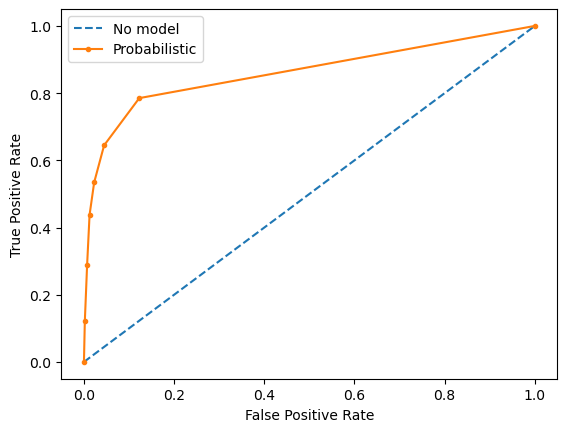

Kneighbors: ROC AUC=0.781


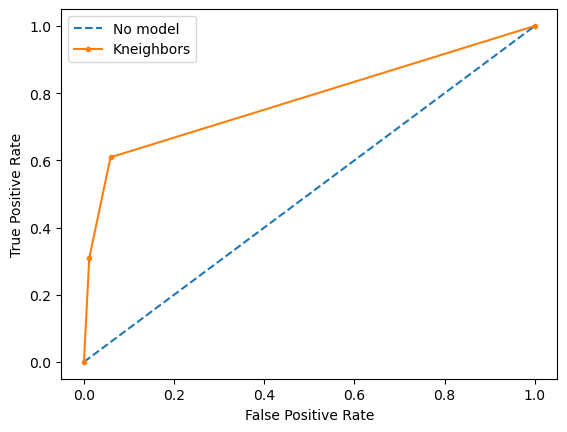

Gradient boosting: ROC AUC=0.879


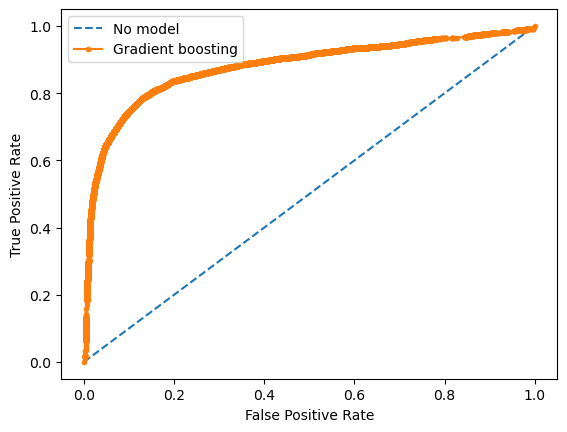

Multilayer perceptron: ROC AUC=0.879


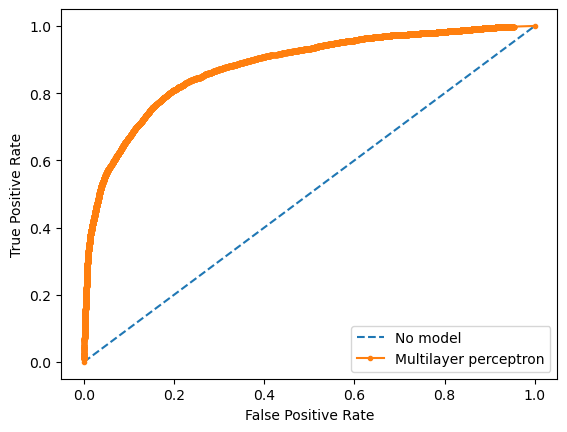

In [84]:
#Se muestra la curva ROC de los modelos
for roc in roc_curve_arr:
    if not existAllZero(roc[1]):
        ns_probs = [0 for _ in range(len(roc[1]))]
        # calculate scores
        ns_auc = roc_auc_score(roc[1], ns_probs)
        lr_auc = roc_auc_score(roc[1], roc[2])
        # summarize scores
        print(f'{modelName(roc[0])}: ROC AUC=%.3f' % (lr_auc))
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(roc[1], ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(roc[1], roc[2])
        # plot the roc curve for the model
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No model')
        plt.plot(lr_fpr, lr_tpr, marker='.', label=modelName(roc[0]))
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # show the legend
        plt.legend()
        # show the plot
        plt.show()
    else:
        print(f"Model {modelName(roc[0])} has no values to display")